## Packages

In [1]:
#%cd /content/drive/MyDrive/MscThesis
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import umap
import pandas as pd
import time
import gwpy
import nds2 # conda config --add channels conda-forge \n conda install python-nds2-client
import numba
import h5py
from gwpy.table import EventTable
from gwpy.table import GravitySpyTable
from gwpy.detector import ChannelList, Channel
from gwpy.time import tconvert
from gwpy.timeseries import TimeSeries #if this does not work, remove h5py and reinstall h5py
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM, DER
from avalanche.logging import InteractiveLogger, TextLogger, CSVLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics, \
mean_scores_metrics, topk_acc_metrics, class_accuracy_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

# log to text file
text_logger = TextLogger(open("multiview_fusion_naive_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()

4


In [2]:
# Set the environment variables
os.environ["GRAVITYSPY_DATABASE_USER"] = "mla"
os.environ["GRAVITYSPY_DATABASE_PASSWD"] = "gl1tch35Rb4d!"

In [3]:
current_dir = %pwd
print(current_dir)

C:\Users\Brian.Baert\Documents\GitHub\MscThesis


In [4]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
#train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
#val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
#test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

In [5]:
O3b_csv = pd.read_csv('Data/data_o3b_high_confidence.csv')

## Load in fractal data

In [6]:
FD_location = 'C:\\Users\\Brian.Baert\\FD_CL\\final_normalized_data.npy'
FD_location_reduced = 'C:\\Users\Brian.Baert\\FD_CL\\reduced_ids_50.npy'

In [7]:
fractal_matrices = np.load(FD_location)
fractal_matrices.shape

(3584, 347, 56)

Because the initial results with the "No Glitch" class where overfitting, we opt for the reduced dataset (less auxiliary channels)

In [8]:
fractal_matrices = np.load(FD_location_reduced)
fractal_matrices.shape

(2688, 50, 56)

In [9]:
fractal_matrices[0]

array([[0.57451844, 0.574585  , 0.61747295, ..., 0.8614793 ,
        0.8710429 , 0.86270547],
       [0.82187957, 0.8134645 , 0.8314725 , ..., 0.87468857,
        0.8983555 , 0.89641106],
       [0.48615664, 0.5589393 , 0.5859381 , ..., 0.81507933,
        0.76803046, 0.7939468 ],
       ...,
       [0.58207494, 0.478571  , 0.5393343 , ..., 0.7123621 ,
        0.6273871 , 0.64899284],
       [0.45105952, 0.30550978, 0.43062353, ..., 0.39758435,
        0.5520664 , 0.39632282],
       [0.40403458, 0.32956344, 0.49127063, ..., 0.8159749 ,
        0.73265237, 0.83331215]], dtype=float32)

In [10]:
#pd_fractal = pd.DataFrame(fractal_matrices.reshape(fractal_matrices.shape[0], -1))
#pd_fractal

In [11]:
no_glitch = fractal_matrices[0:895]
whistle = fractal_matrices[896:1791]
tomte = fractal_matrices[1792:2687]
scattered_light = fractal_matrices[2688:3584]

In [12]:
labels = []
#labels.extend(['No_Glitch'] * 896)
labels.extend(['Whistle'] * 896)
labels.extend(['Tomte'] * 896)
labels.extend(['Scattered_Light'] * 896)
len(labels)
labels=np.array(labels)
len(labels)

2688

## Visualization

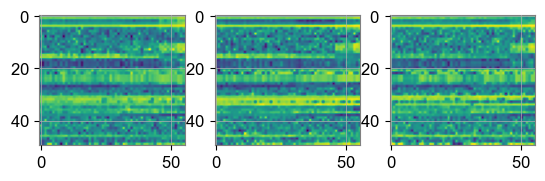

Label for fig 1 is Whistle, fig 2 is Tomte, fig 3 is Scattered_Light


In [13]:
plt.close()
fig, ax = plt.subplots(1,3)
ax[0].imshow(fractal_matrices[0])
ax[1].imshow(fractal_matrices[897])
ax[2].imshow(fractal_matrices[1793])
plt.show()
print(f'Label for fig 1 is {labels[0]}, fig 2 is {labels[897]}, fig 3 is {labels[1793]}')

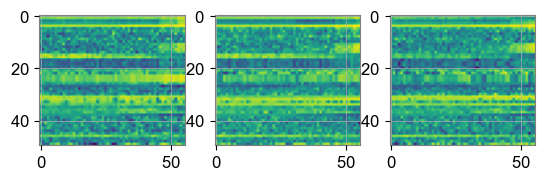

Label for fig 1 is Whistle, fig 2 is Tomte, fig 3 is Scattered_Light


In [14]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(fractal_matrices[1])
ax[1].imshow(fractal_matrices[898])
ax[2].imshow(fractal_matrices[1794])
plt.show()
print(f'Label for fig 1 is {labels[1]}, fig 2 is {labels[898]}, fig 3 is {labels[1793]}')

In [15]:
fd_mean = np.mean(fractal_matrices, axis=2)
fd_std = np.std(fractal_matrices, axis=2)
fd_max = np.max(fractal_matrices, axis=2)
fd_min = np.min(fractal_matrices, axis=2)
fd_median = np.median(fractal_matrices, axis=2)
fractal_matrices_transformed = np.stack((fd_mean, fd_median, fd_std, fd_min, fd_max), axis=2)
fractal_matrices_transformed.shape

(2688, 50, 5)

## Preprocess data

In [16]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(fractal_matrices, labels, test_size=0.2, random_state=123)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
# Verify the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (1720, 50, 56)
X_test shape: (538, 50, 56)
X_val shape: (430, 50, 56)
Y_train shape: (1720,)
Y_test shape: (538,)
Y_val shape: (430,)


In [17]:
label_mapping = {0: 'No_Glitch', 1: 'Whistle', 2: 'Tomte', 3: 'Scattered_Light'}
# Replace values using the dictionary
#classes = ['No_Glitch', 'Whistle', 'Tomte', 'Scattered_Light']
classes = ['Whistle', 'Tomte', 'Scattered_Light']
print(classes)

['Whistle', 'Tomte', 'Scattered_Light']


In [18]:
import torch
from sklearn.preprocessing import LabelEncoder
X_train = torch.from_numpy(X_train).float()  
X_test = torch.from_numpy(X_test).float()
X_val = torch.from_numpy(X_val).float()
# Create a label encoder
le = LabelEncoder()
# Fit the encoder on the training labels
le.fit(Y_train)
le.fit(Y_test)
le.fit(Y_val)
# Convert string labels to numerical labels
Y_train_encoded = le.transform(Y_train)
Y_test_encoded = le.transform(Y_test)
Y_val_encoded = le.transform(Y_val)
# Convert the encoded labels to a long tensor
Y_train_labels = torch.from_numpy(Y_train_encoded).long()
Y_test_labels = torch.from_numpy(Y_test_encoded).long()
Y_val_labels = torch.from_numpy(Y_val_encoded).long()

In [19]:
# Assuming your data and labels are loaded into 'data' and 'labels' variables
train_data = my_dataloaders.FractalDataset(X_train, Y_train_labels)
train_data_av = AvalancheDataset(train_data)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = my_dataloaders.FractalDataset(X_test, Y_test_labels)
test_data_av = AvalancheDataset(test_data)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
val_data = my_dataloaders.FractalDataset(X_val, Y_val_labels)
val_data_av = AvalancheDataset(val_data)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)         
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

FractalDimensionConvNet(
  (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3584, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)

In [20]:
#x = torch.randn(16,21,56)
x = torch.randn(16,50,56)
output = model(x)
print(output.shape)

torch.Size([16, 3])


## DL Baseline

In [25]:
import torch.optim as optim

# Define hyperparameters
learning_rate = 0.0001 # reduce it + add early stopping
momentum=0.9
epochs = 100
patience = 4
best_loss = float('inf')
best_epoch = 0
early_stop = False

criterion = CrossEntropyLoss()
# Define optimizer (e.g., Adam optimizer)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-7, weight_decay=1e-5)

# Loop through epochs
for epoch in range(epochs):
    # Loop through data batches
    for data_X, labels_Y in train_loader:
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data_X)
        #print(outputs)
        predicted, _ = torch.max(outputs, 1)
        #print(predicted)
        loss = criterion(predicted, labels_Y.float())  # Convert labels to float for loss calculation

        # Backward pass and parameter update
        loss.backward()
        optimizer.step()

    #scheduler.step()
    # Print training information (optional)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Check for early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
    elif (epoch - best_epoch) >= patience:
        print(f'Early stopping at epoch {epoch+1}, best loss was {best_loss:.4f} at epoch {best_epoch+1}')
        early_stop = True
        break

if not early_stop:
    torch.save(model.state_dict(), 'Models/FD_basline_model.pth')
    print('Best model saved to best_model.pth')
    print('Finished training')

Epoch [1/100], Loss: 34.8015
Epoch [2/100], Loss: 18.8049
Epoch [3/100], Loss: 9.9447
Epoch [4/100], Loss: 12.9091
Epoch [5/100], Loss: 13.1477
Epoch [6/100], Loss: 8.3161
Epoch [7/100], Loss: 17.4011
Epoch [8/100], Loss: 11.3569
Epoch [9/100], Loss: 9.2616
Epoch [10/100], Loss: 19.4813
Early stopping at epoch 10, best loss was 8.3161 at epoch 6


In [26]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 249.76348876953125 ms


In [27]:
y_pred_list

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

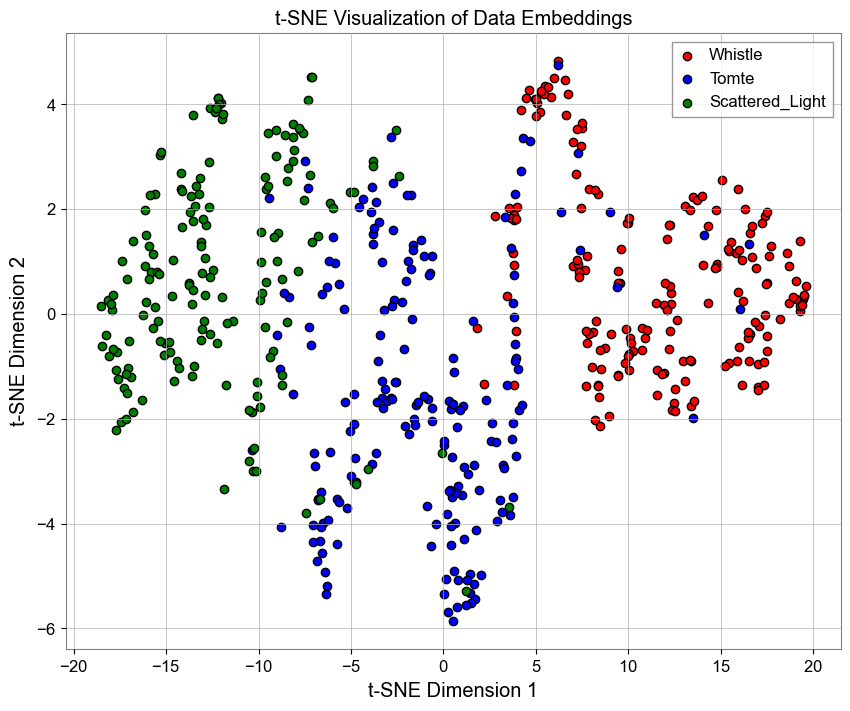

plot_tSNE_data_embedding: 1611.2182140350342 ms


In [28]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_test.png")

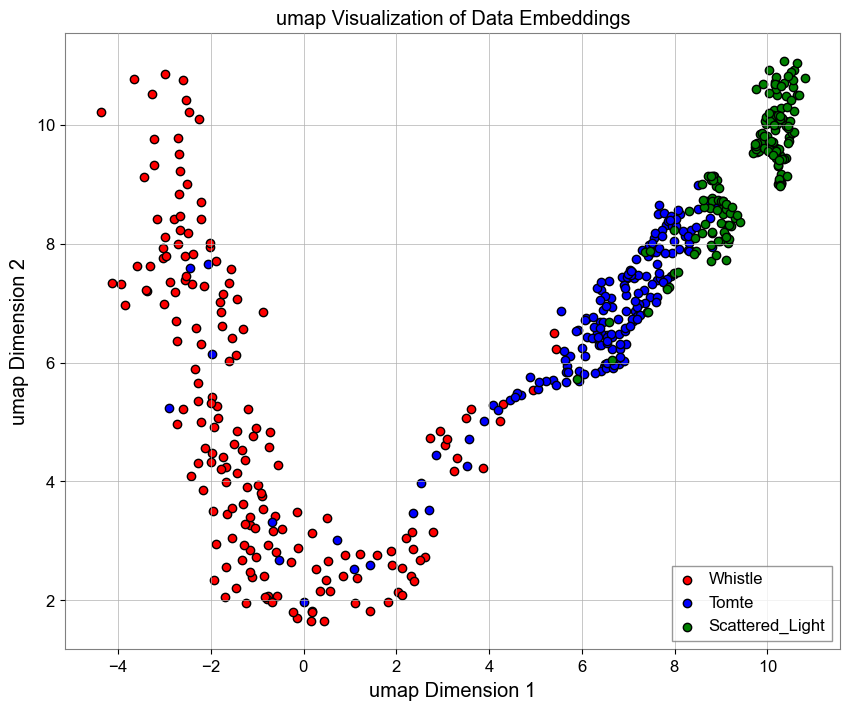

plot_umap_data_embedding: 12764.372110366821 ms


In [29]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_test.png")

In [30]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

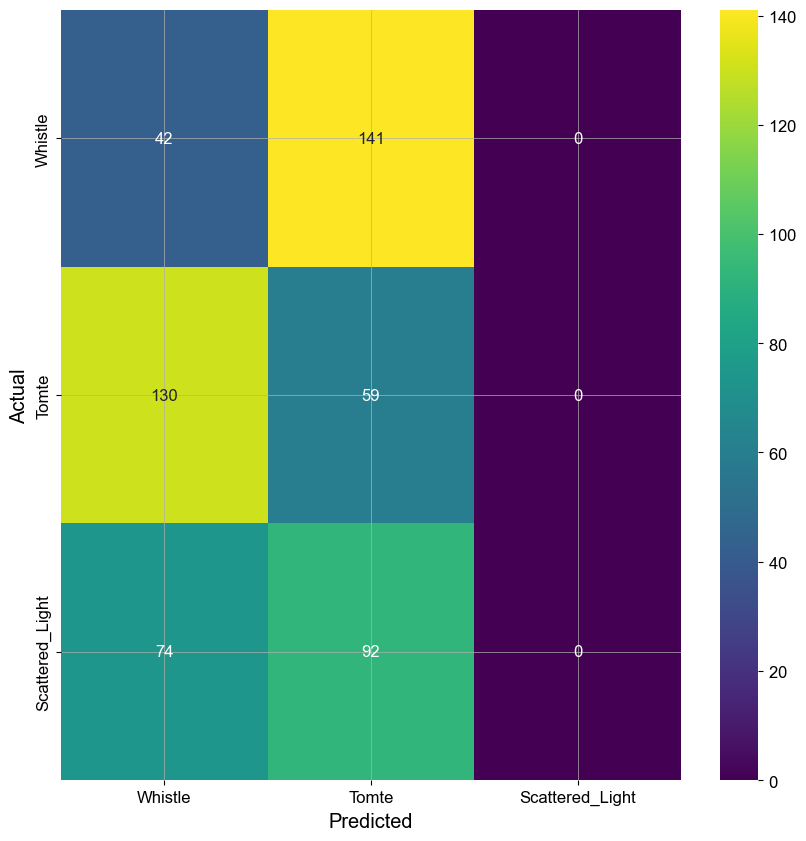

In [31]:
my_utils.plot_confusion_matrix(cm, classes, 'cm_FD_model.png')

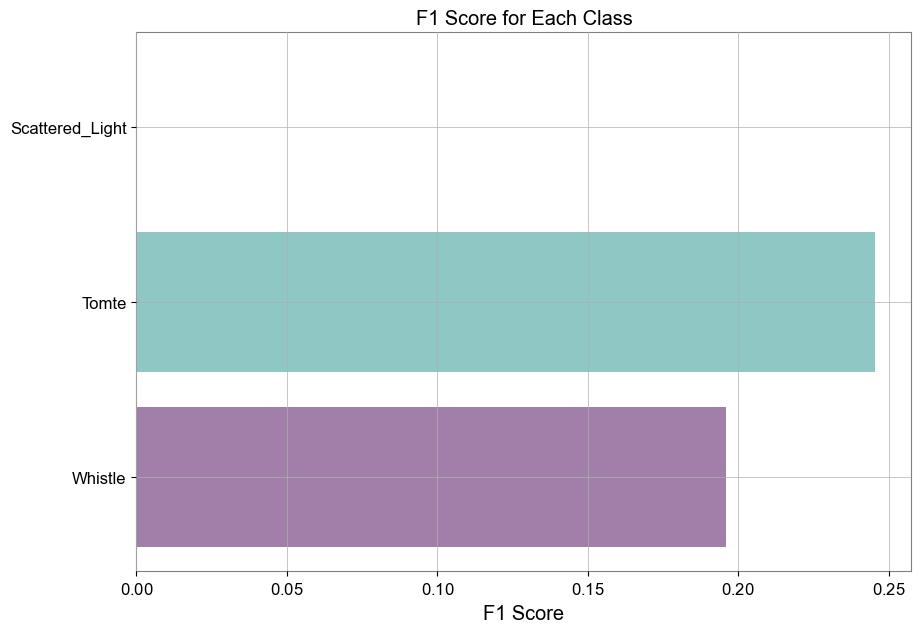

In [32]:
my_utils.plot_f1_scores(f1, classes, 'f1_FD_model.png')

## Naive Continual strategy

In [21]:
### Assuming your data and labels are loaded into 'data' and 'labels' variables
train_data = my_dataloaders.FractalDataset(X_train, Y_train_labels)
train_data_av = AvalancheDataset(train_data)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = my_dataloaders.FractalDataset(X_test, Y_test_labels)
test_data_av = AvalancheDataset(test_data)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
val_data = my_dataloaders.FractalDataset(X_val, Y_val_labels)
val_data_av = AvalancheDataset(val_data)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)         
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

FractalDimensionConvNet(
  (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3584, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)

In [22]:
train_data_av.targets = [label.tolist() for i, label in enumerate(train_data.labels)]
test_data_av.targets = [label.tolist() for i, label in enumerate(test_data.labels)]
val_data_av.targets = [label.tolist() for i, label in enumerate(val_data.labels)]

In [23]:
train_data_av.uniques = list(set(train_data.labels))
test_data_av.uniques = list(set(test_data.labels))
val_data_av.uniques = list(set(val_data.labels))

In [24]:
batch = next(iter(train_data))
matrix, label = batch
print(matrix.shape)
print(label)

torch.Size([50, 56])
tensor(0)


In [25]:
bm = nc_benchmark(
    train_dataset=train_data_av,
    test_dataset=val_data_av,
    n_experiences=3,
    shuffle=True,
    seed=1234,
    task_labels=False
)

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forward_transfer_metrics(experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    mean_scores_metrics(on_train=True, on_eval=True),
    topk_acc_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=16, train_epochs=15, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_data)), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x000002D1B25C77C0>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 35/35 [00:05<00:00,  6.04it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0185
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9928
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9928
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:03<00:00,  9.16it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:03<00:00,  9.29it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/tr

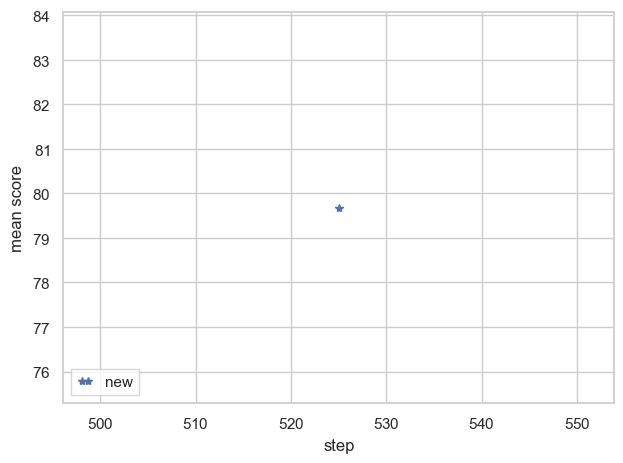

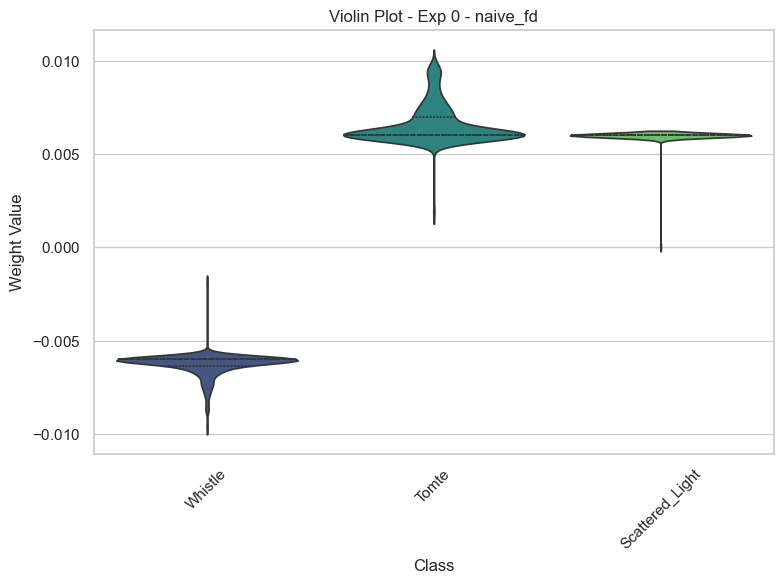

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:04<00:00,  7.69it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.6129
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9075
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9167
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.8983
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:04<00:00,  8.47it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0705
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9786
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9847
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9724
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:03<00:00, 10.05it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0485
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9829
	Top1_ClassAc

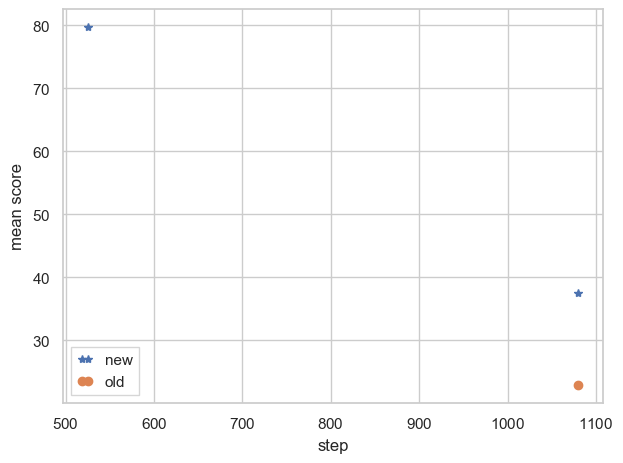

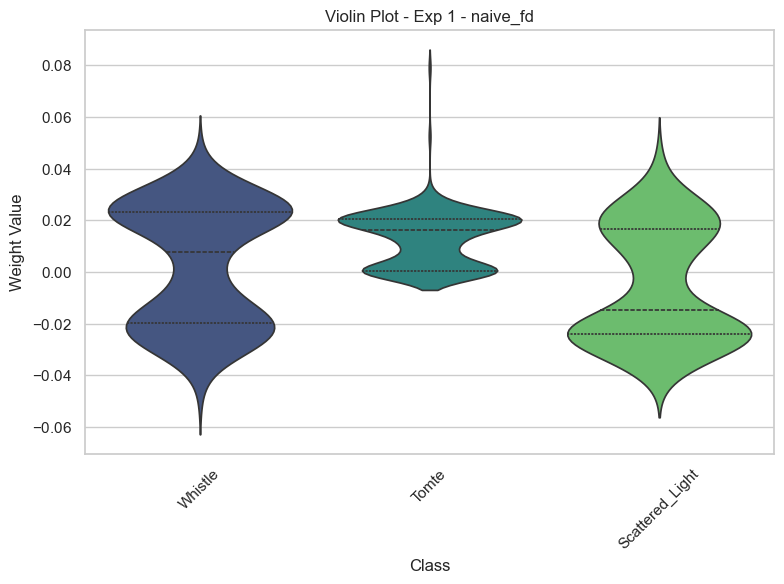

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:04<00:00,  8.49it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.4331
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6207
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.2098
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.8185
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.6275
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:03<00:00,  9.89it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6670
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6854
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.0605
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.8579
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9260
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:03<00:00, 11.40it/s]
Epoch 2 en

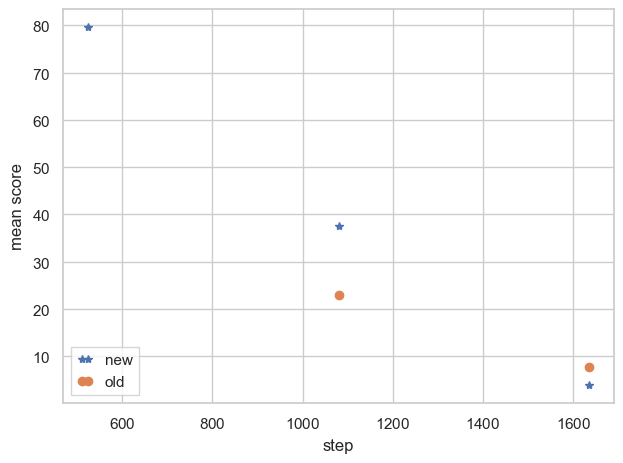

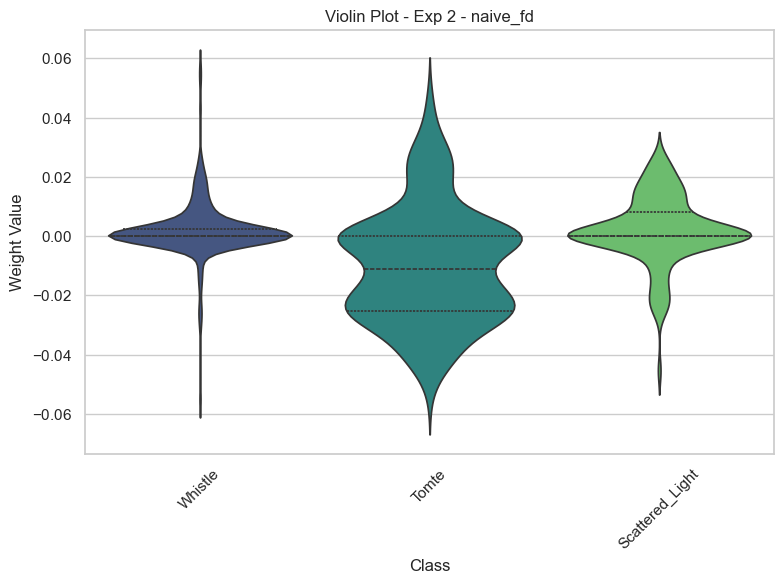

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 200384.33074951172 ms


In [69]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'naive_fd')

In [70]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 388.63253593444824 ms


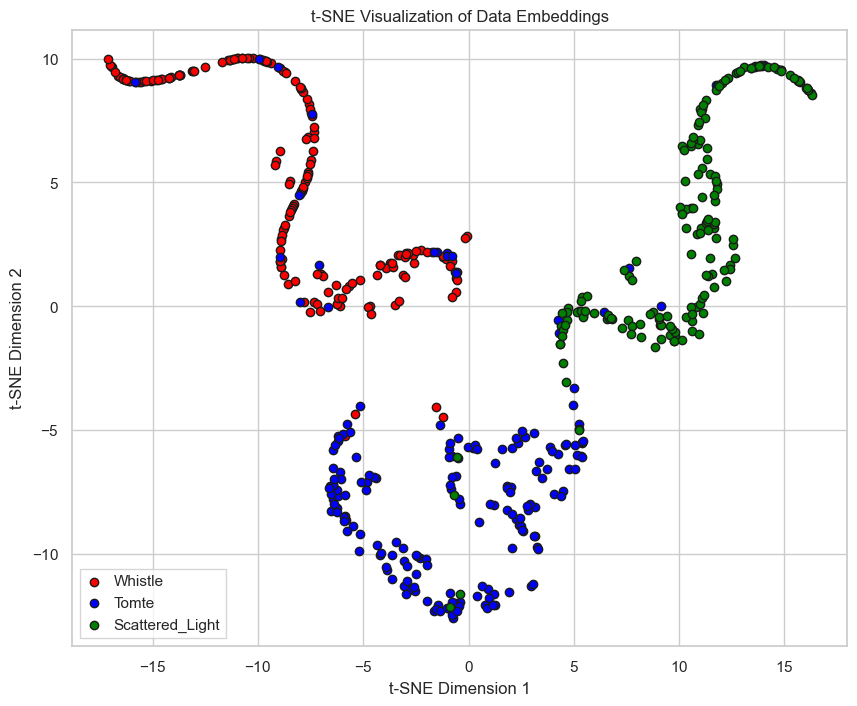

plot_tSNE_data_embedding: 2206.6547870635986 ms


In [71]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_naive_test.png")

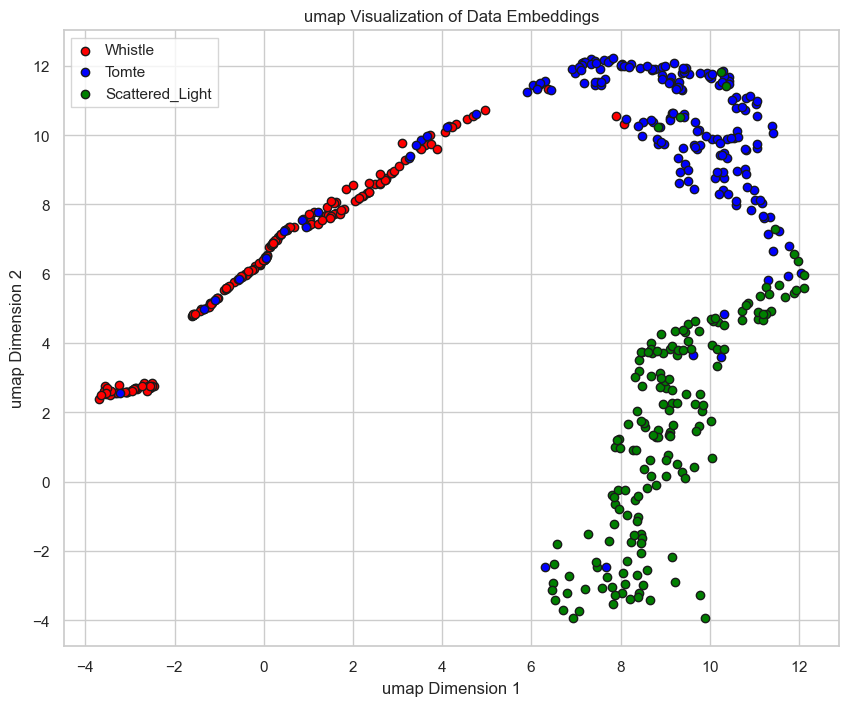

plot_umap_data_embedding: 11379.482507705688 ms


In [72]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_naive_test.png")

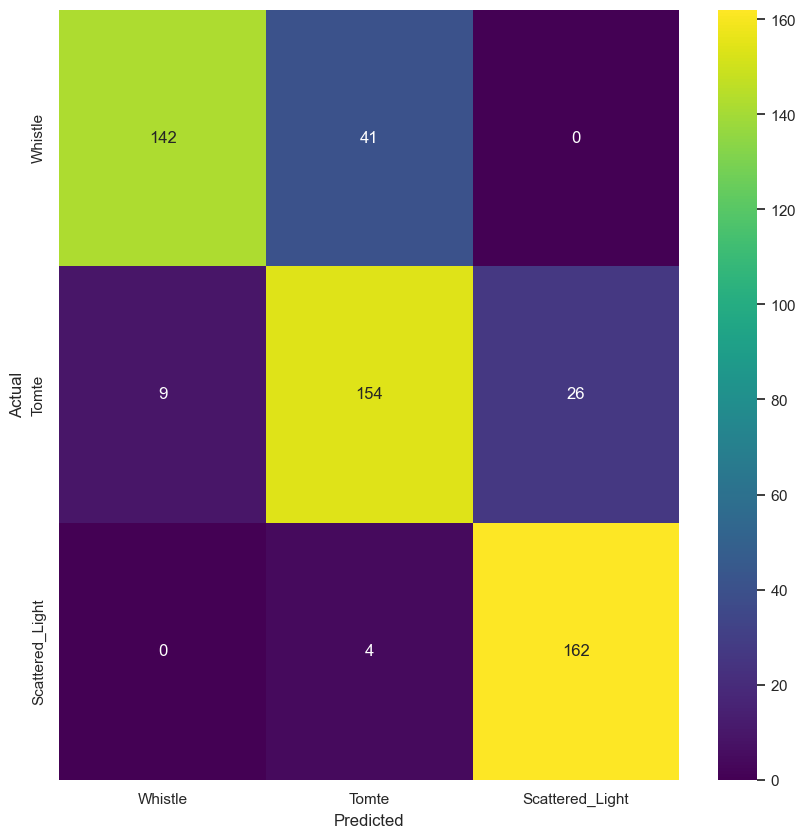

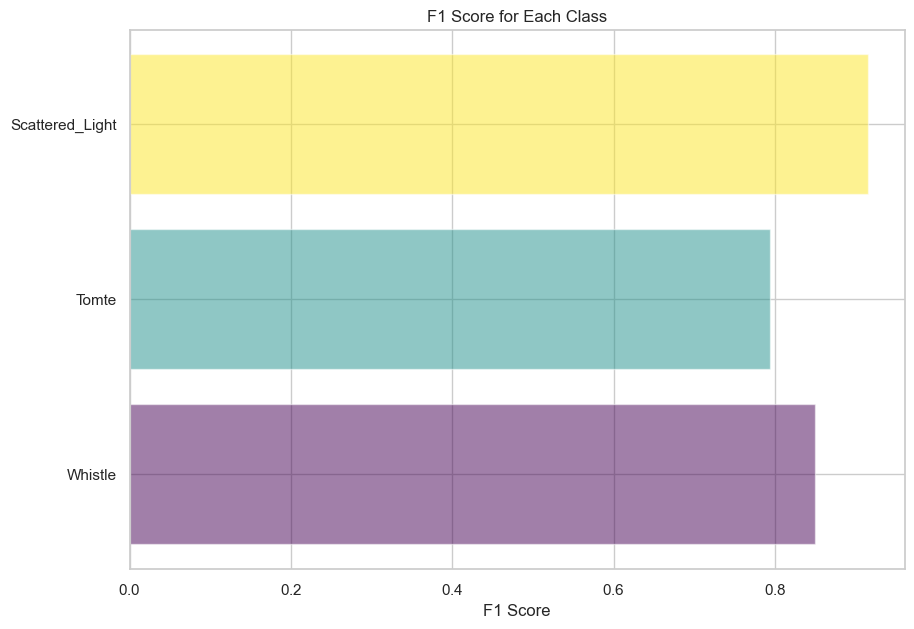

In [73]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'cm_FD_model_naive.png')
my_utils.plot_f1_scores(f1, classes, 'f1_FD_model_naive.png')

In [74]:
f1

array([0.8502994 , 0.79381443, 0.91525424])

## LwF Continual strategy

In [119]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY 
# ALPHA AND TEMPERATURE are taken from the paper by Oren & Wolf - "In defense of the Learning Without Forgetting for Task Incremental Learning"
cl_strategy = LwF(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.25, temperature=2.0, 
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_data))] #Early stopping is not used here because LwF does not inherently support Early Stopping
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x000001F63BE63520>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 13.43it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0933
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9738
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9738
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 13.99it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000


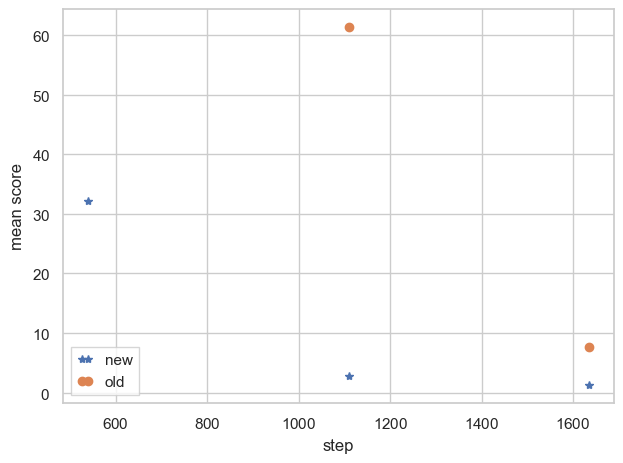

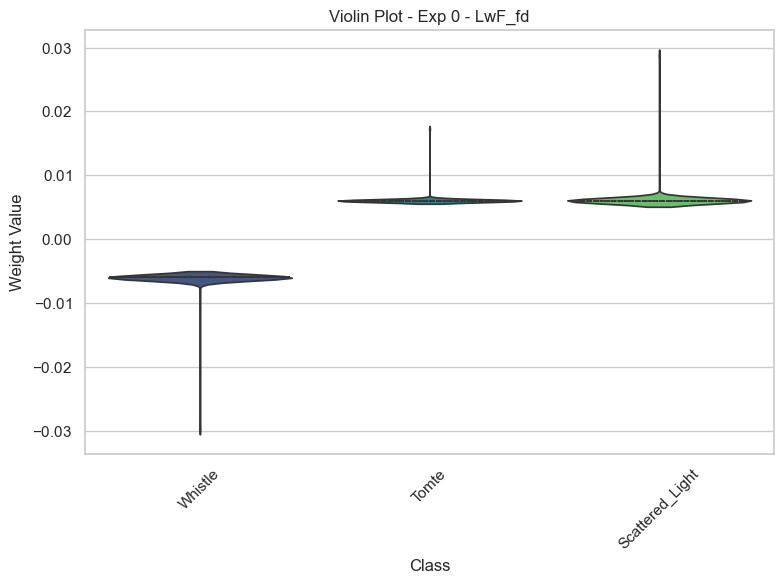

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 38/38 [00:04<00:00,  8.74it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.1797
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9049
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9074
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9024
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:04<00:00,  8.19it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7785
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9708
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9769
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9646
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:04<00:00,  8.82it/s]
Epoch 2 en

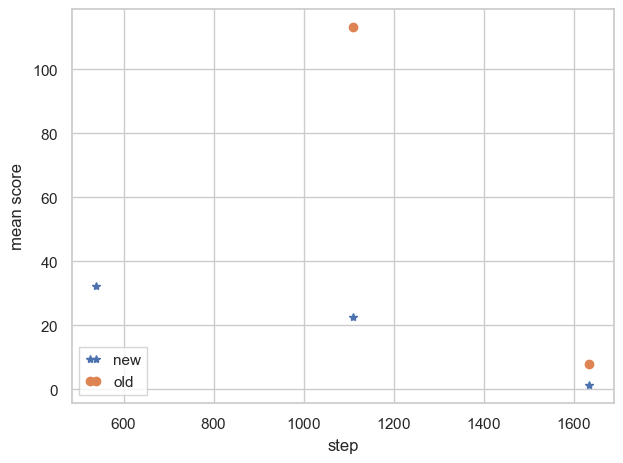

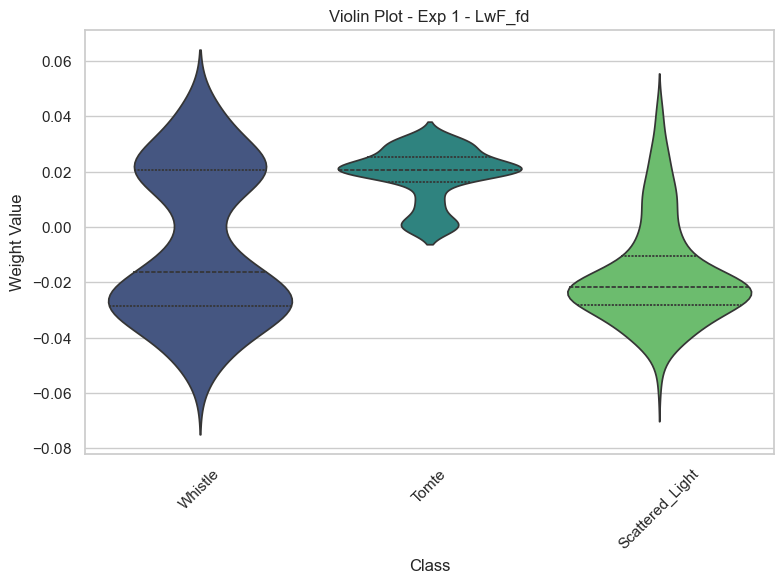

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 35/35 [00:03<00:00, 11.40it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.9713
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4798
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.7022
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.3617
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.4965
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:03<00:00, 10.94it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9824
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6181
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9433
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.7631
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:03<00:00, 11.08it/s]
Epoch 2 en

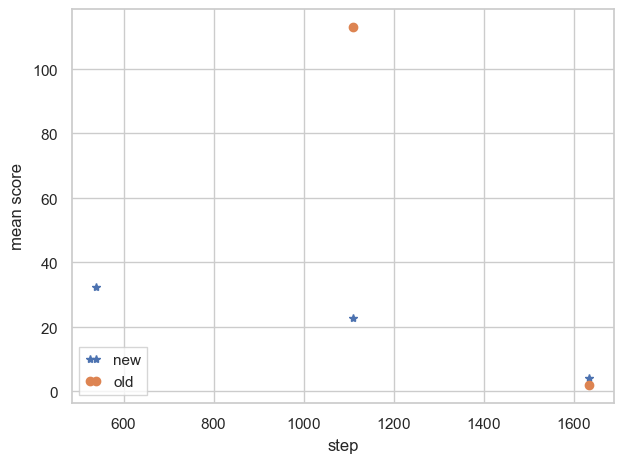

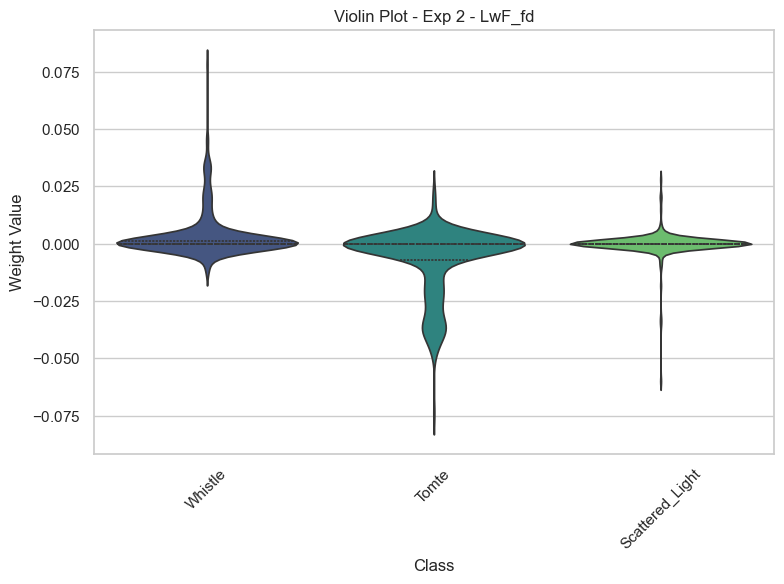

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 159629.33039665222 ms


In [120]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'LwF_fd')

In [121]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 254.1637420654297 ms


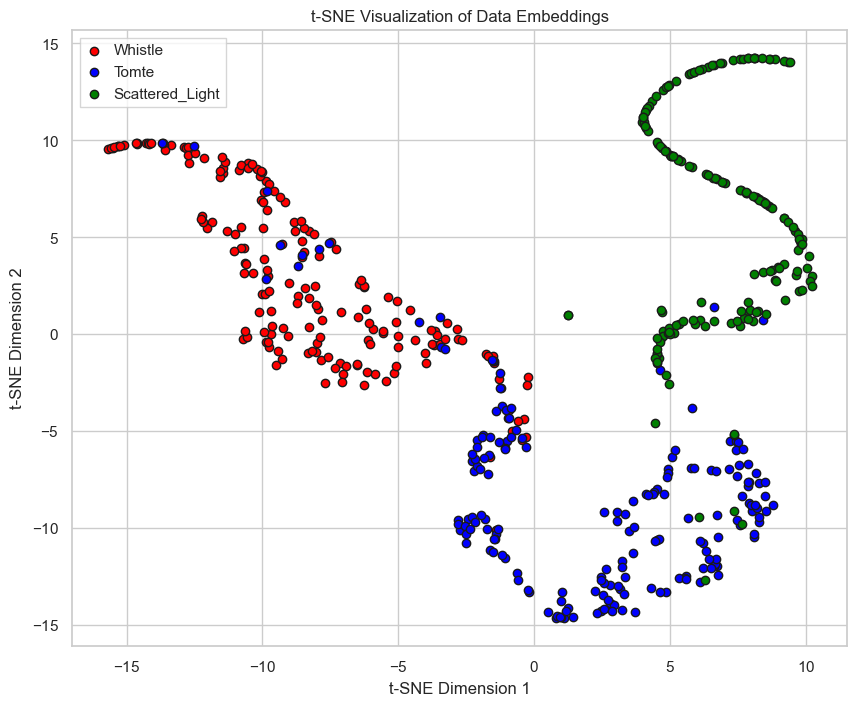

plot_tSNE_data_embedding: 1486.1857891082764 ms


In [122]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_LwF_test.png")

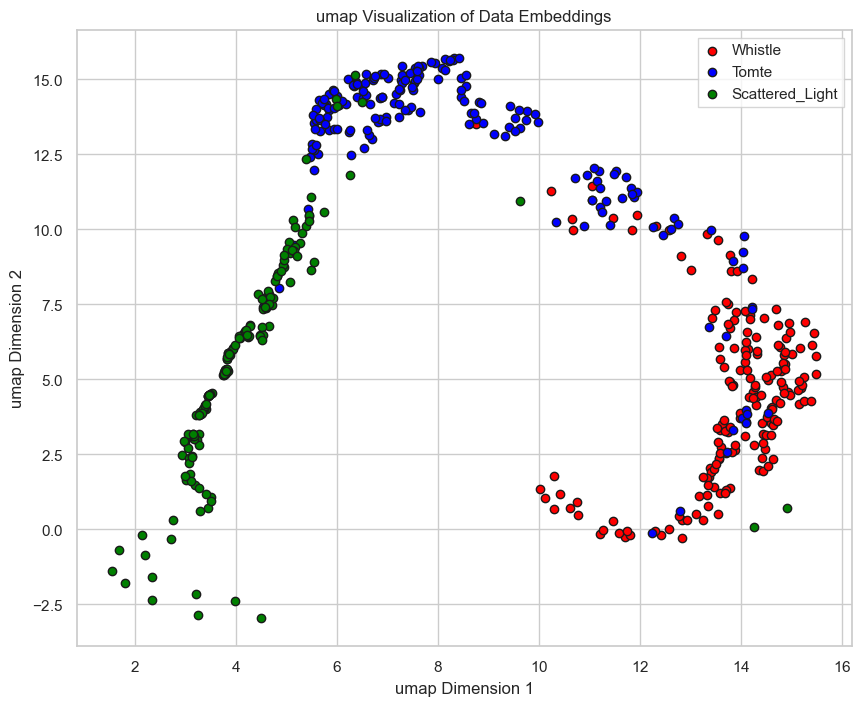

plot_umap_data_embedding: 7328.517436981201 ms


In [123]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_LwF_test.png")

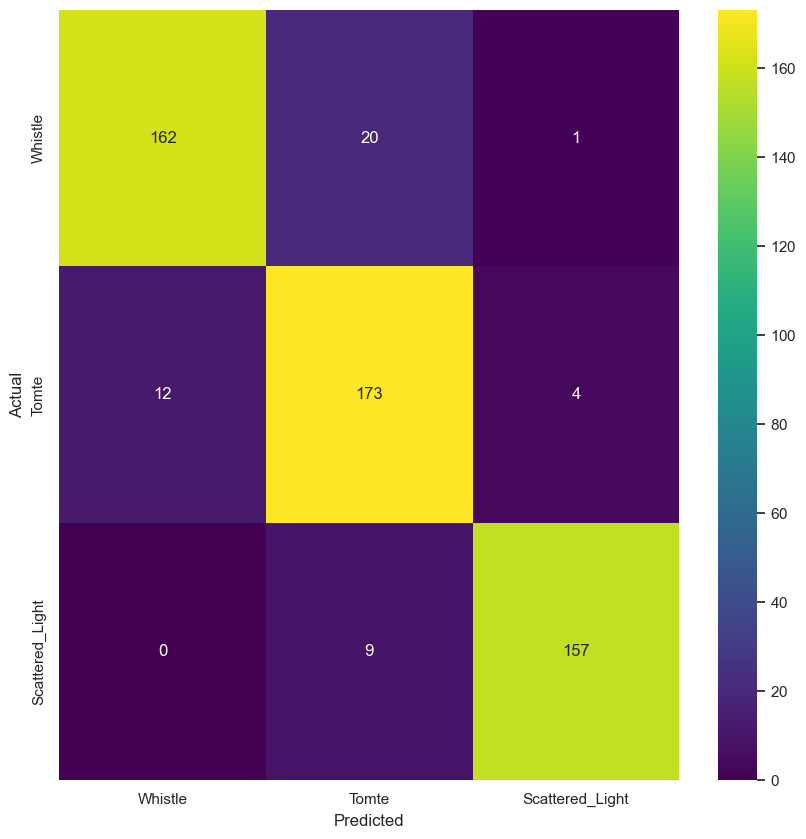

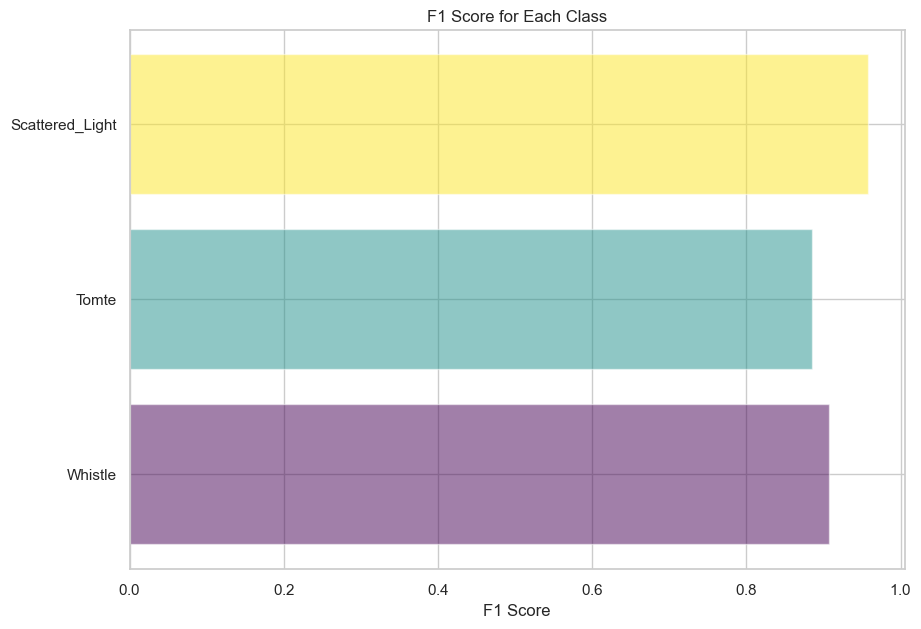

In [124]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_LwF.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_LwF.png')

## AGEM Continual Strategy

In [44]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY
cl_strategy = AGEM(
    model=model, optimizer=optimizer, criterion=criterion, patterns_per_exp=200,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_data)), AGEMPlugin(patterns_per_experience=200, sample_size=16)]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.AGEM object at 0x0000026A3850CE50>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:04<00:00,  7.51it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0826
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9771
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9771
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:14<00:00,  2.55it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000

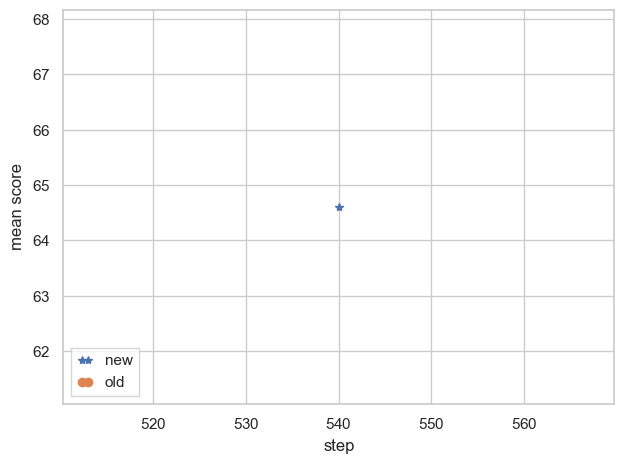

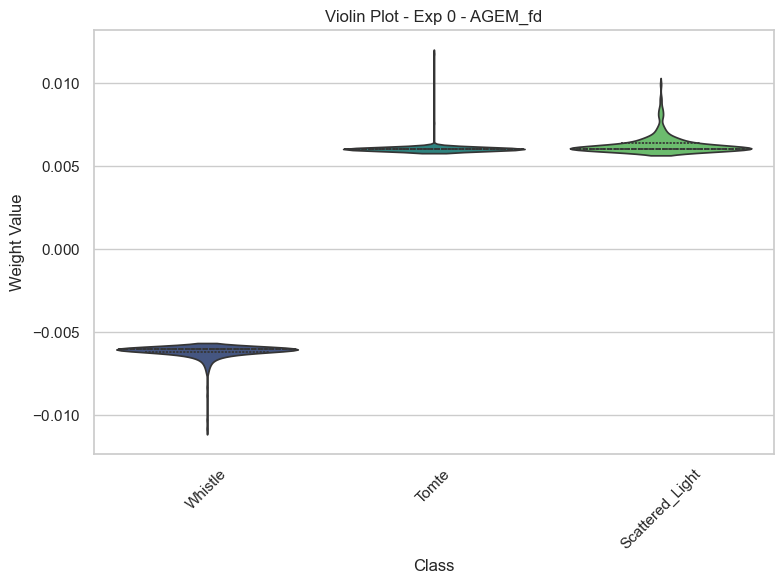

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 38/38 [00:11<00:00,  3.32it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5021
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:08<00:00,  4.28it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5021
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:09<00:00,  4.02it/s]
Epoch 2 ended.
	

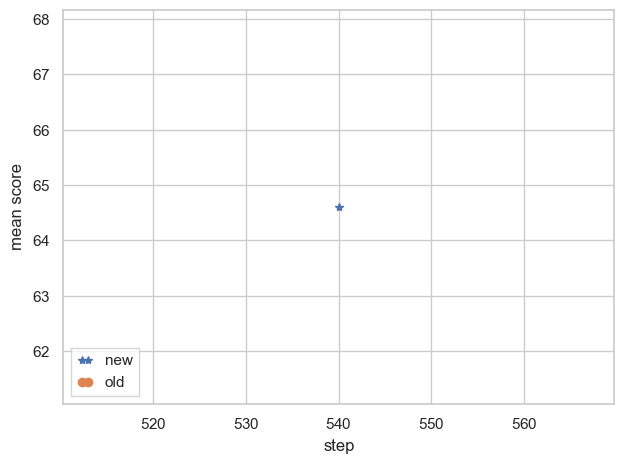

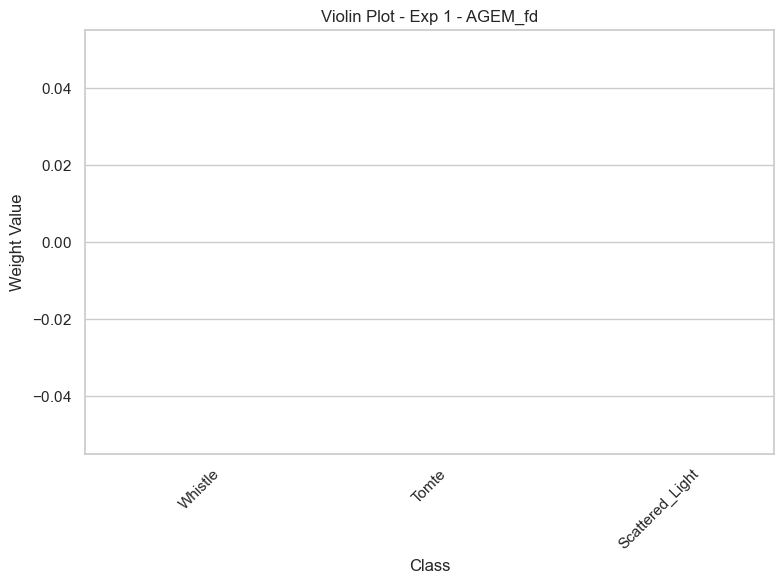

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 35/35 [00:09<00:00,  3.64it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2493
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:09<00:00,  3.53it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2502
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:09<00:00,  3.80it/s]
Epoch 2 ended.
	

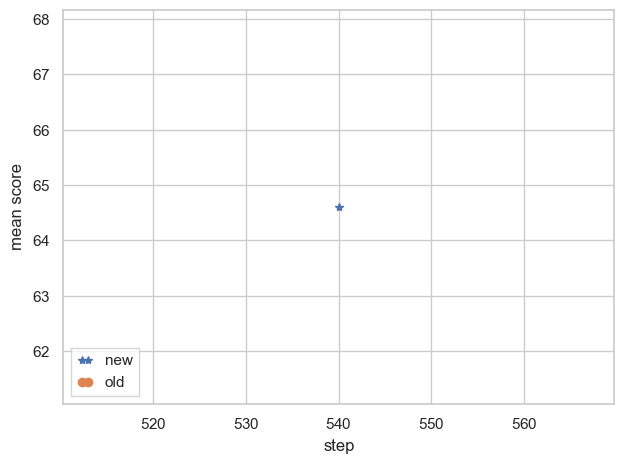

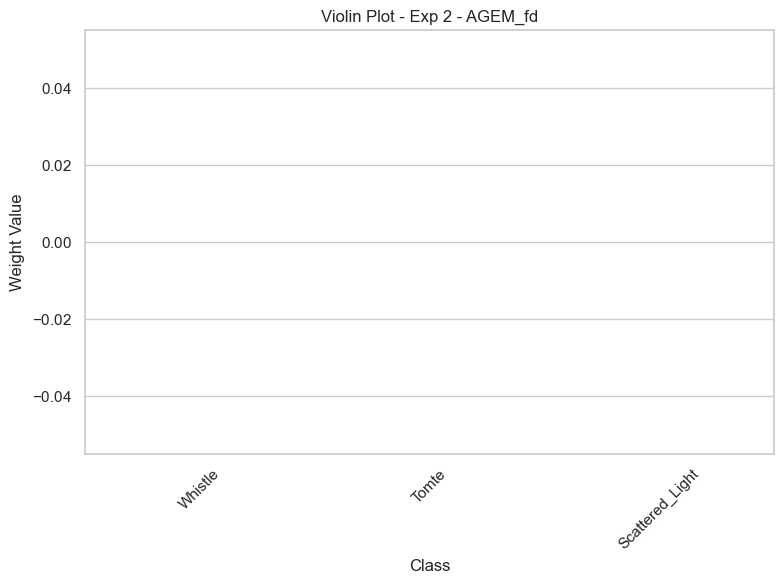

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 513141.04890823364 ms


In [45]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'AGEM_fd', scr=False)

In [46]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 282.26256370544434 ms


In [ ]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_AGEM_test.png")

In [ ]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_AGEM_test.png")

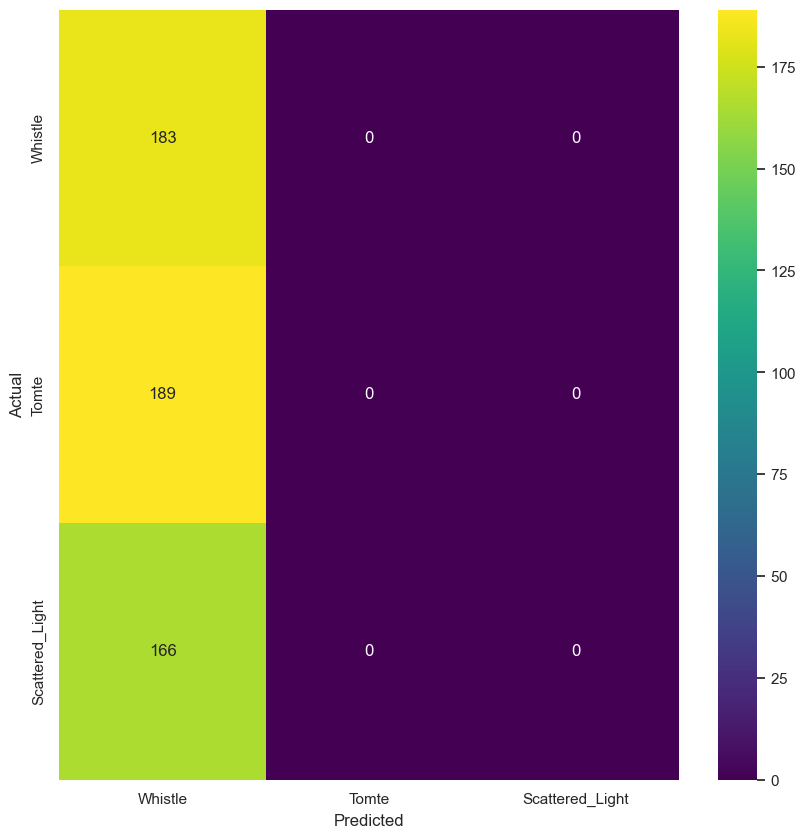

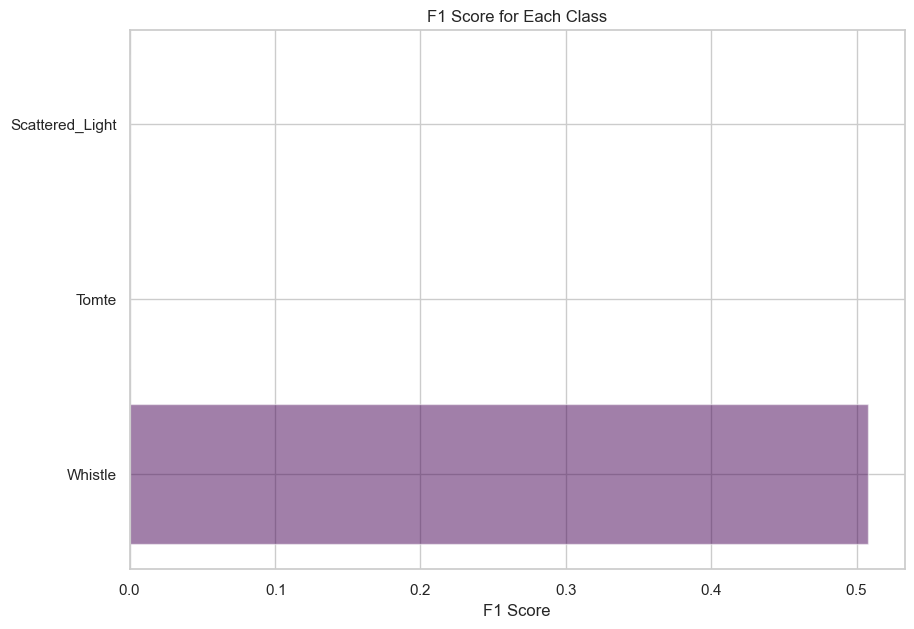

In [48]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_AGEM.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_AGEM.png')

## EWC Continual Strategy

In [33]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY
cl_strategy = EWC(
    model=model, optimizer=optimizer, criterion=criterion, ewc_lambda=0.1,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_data))]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.EWC object at 0x0000026A38458280>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 14.09it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0186
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9894
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9894
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 13.78it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000


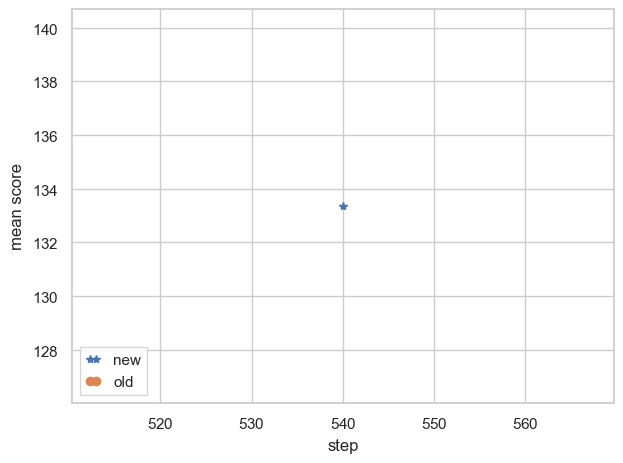

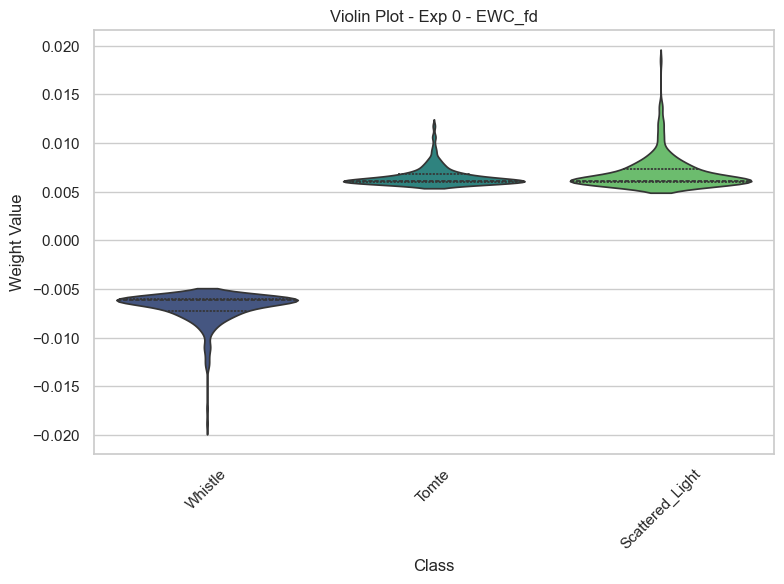

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 38/38 [00:05<00:00,  6.36it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.8295
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9413
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9399
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9428
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:07<00:00,  4.82it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9917
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9606
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9716
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9495
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:06<00:00,  6.20it/s]
Epoch 2 en

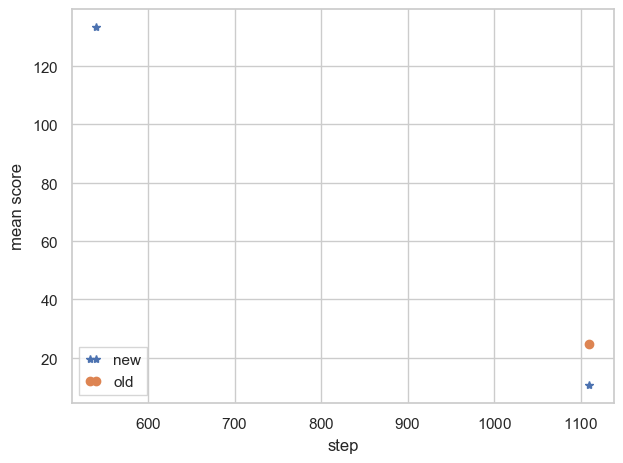

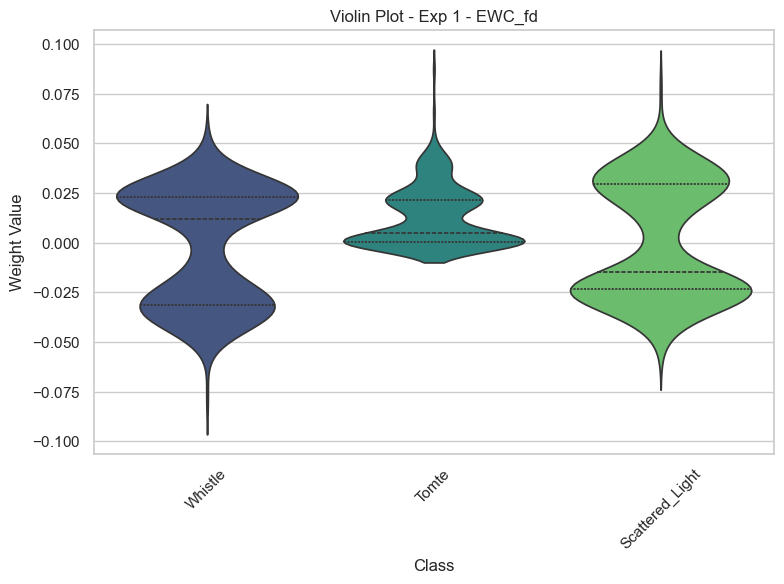

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 35/35 [00:06<00:00,  5.04it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0897
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7283
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.6654
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.7460
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.7535
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:07<00:00,  4.93it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4017
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8293
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.8413
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.8265
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.8235
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:06<00:00,  5.26it/s]
Epoch 2 en

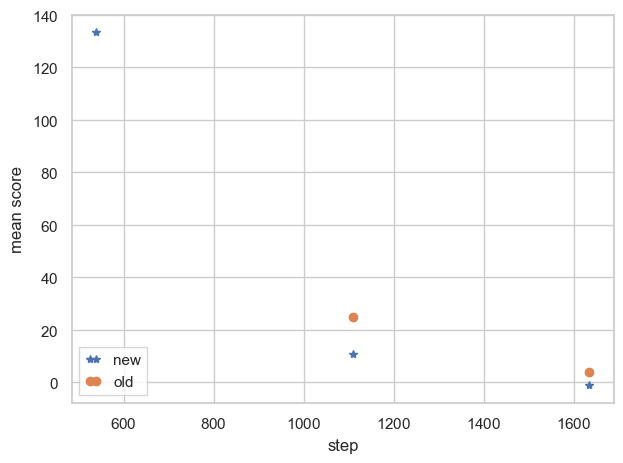

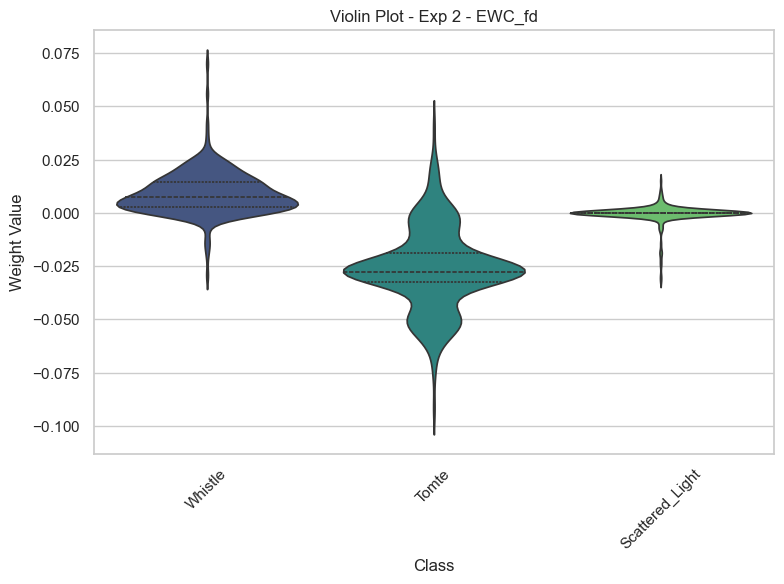

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 241727.04815864563 ms


In [34]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'EWC_fd', scr=False)

In [35]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 311.6168975830078 ms


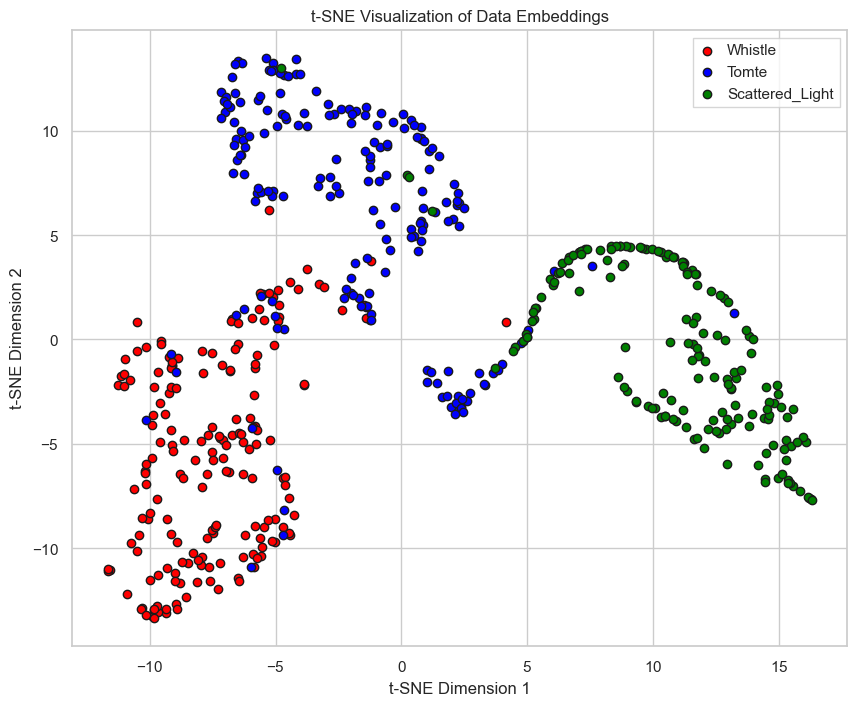

plot_tSNE_data_embedding: 1414.6130084991455 ms


In [36]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_EWC_test.png")

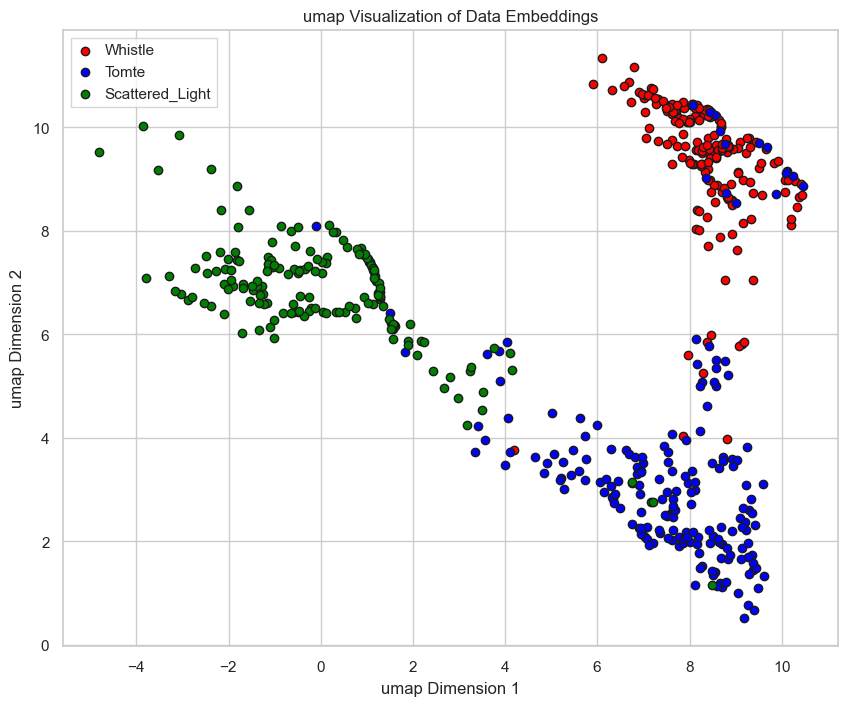

plot_umap_data_embedding: 13905.329704284668 ms


In [37]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_EWC_test.png")

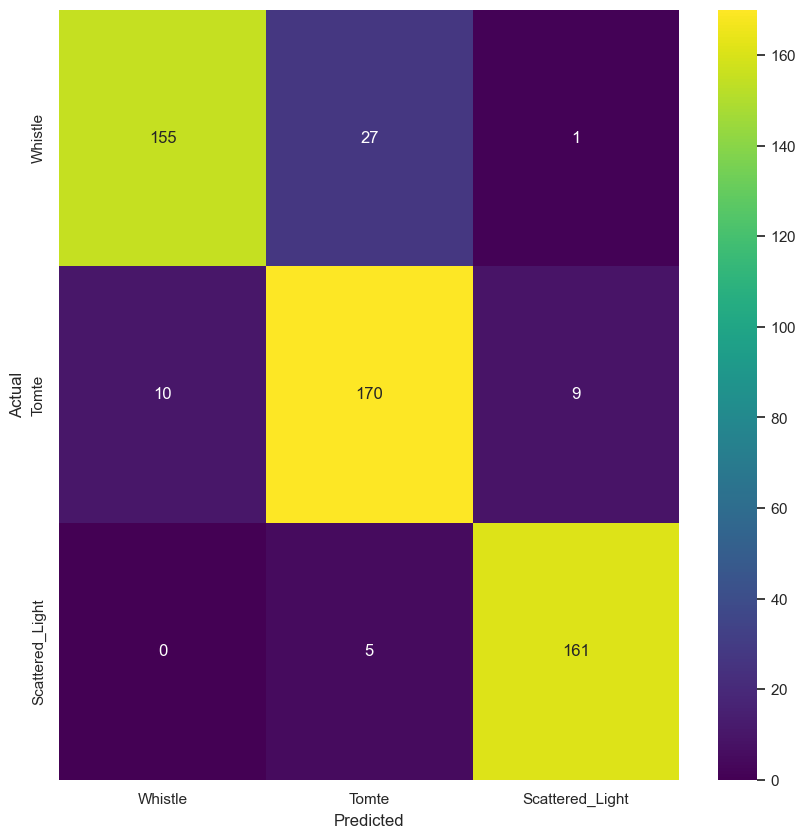

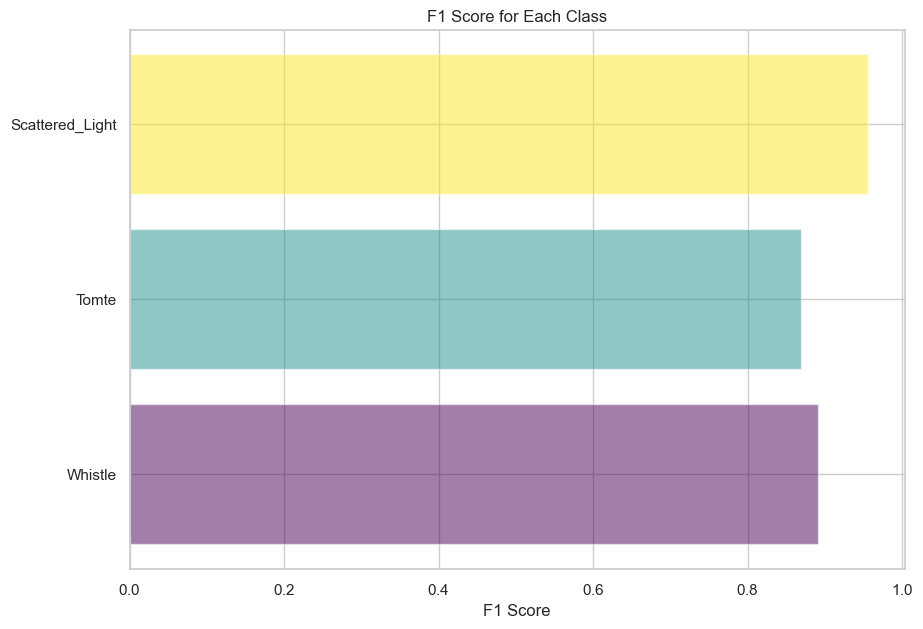

array([0.8908046 , 0.86956522, 0.95548961])

In [38]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_EWC.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_EWC.png')
f1

## DER Continual Strategy

In [156]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY
cl_strategy = DER(
    model=model, optimizer=optimizer, criterion=criterion, alpha=1.0, beta=0, mem_size=500,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    #plugins=[ReplayPlugin(mem_size=2*len(train_set))]
)

Starting experiment with strategy: <avalanche.training.supervised.der.DER object at 0x000001F63F91E950>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:02<00:00, 14.48it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0550
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9725
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9725
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:02<00:00, 13.46it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:02<00:00, 13.13it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_

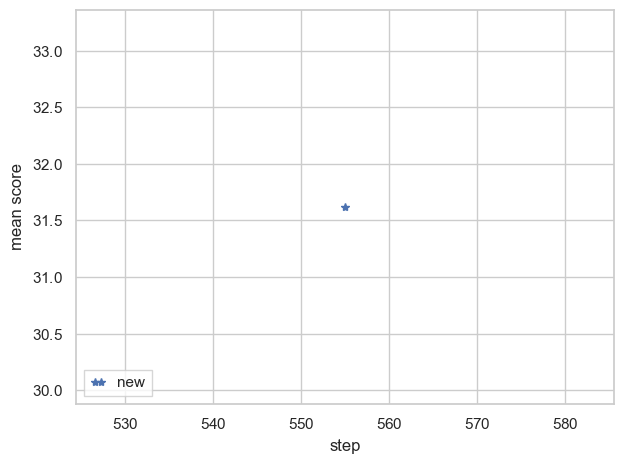

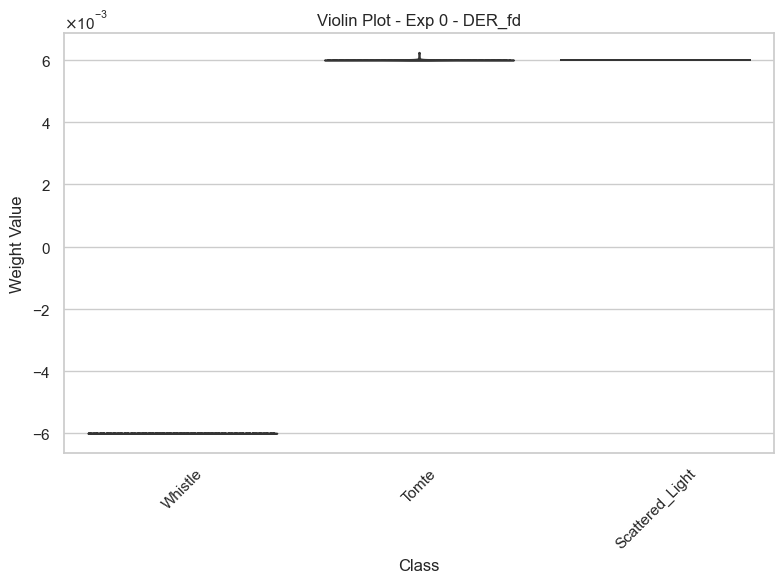

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 12.67it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 132.9708
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8059
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9653
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.6457
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.26it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 11.0764
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9817
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9634
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.31it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 9.0698
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9939
	Top1_Clas

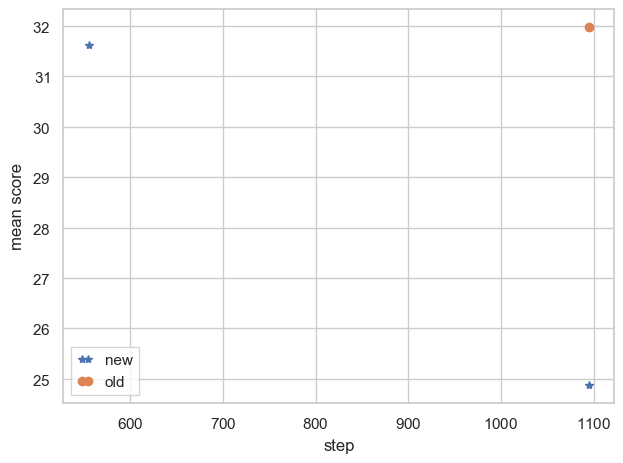

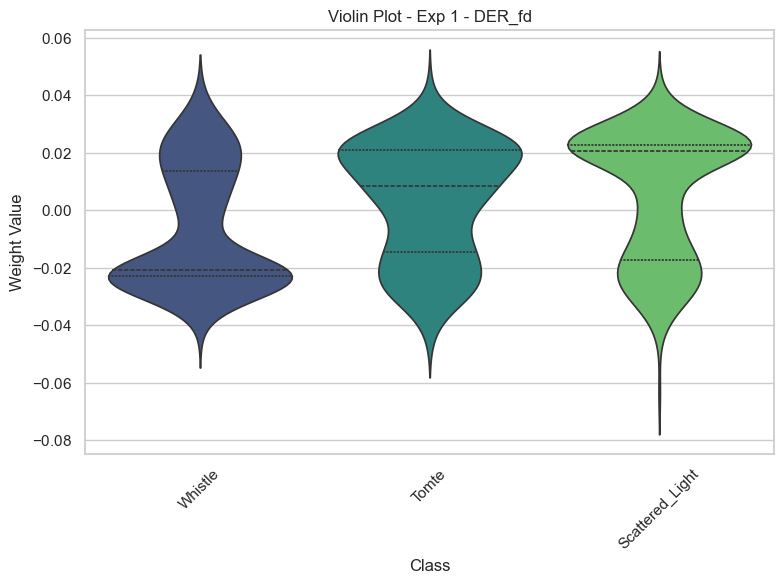

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 12.72it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 121.4064
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5026
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0106
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9720
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.80it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 104.8160
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6121
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9901
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.2314
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9818
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.90it/s]
Epoch 

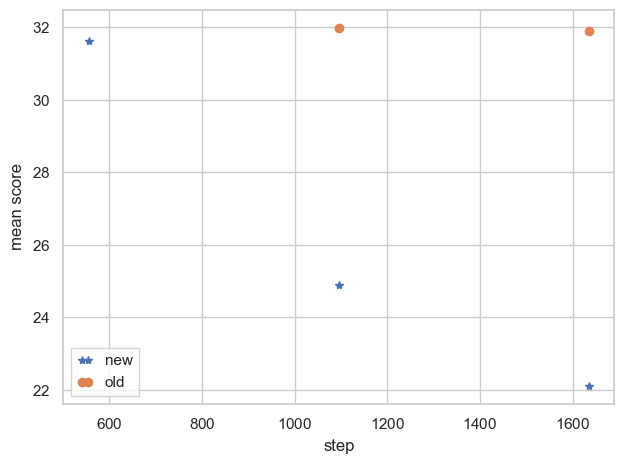

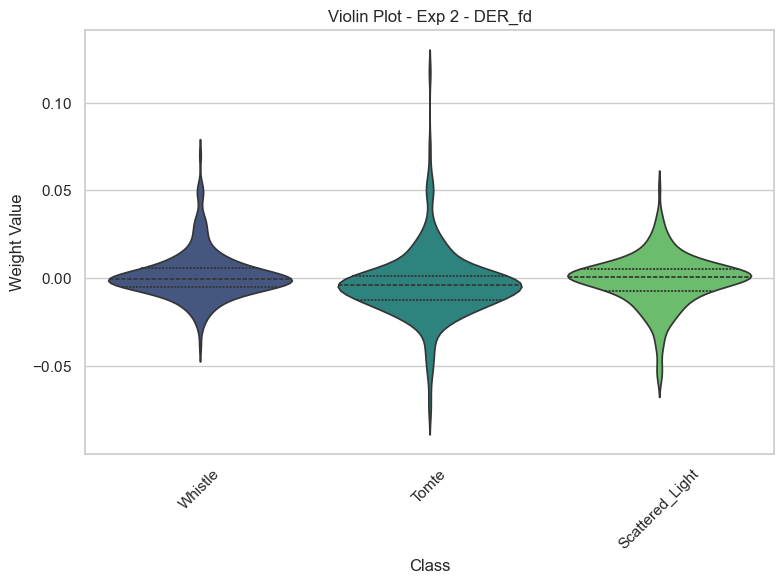

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 134265.95854759216 ms


In [157]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'DER_fd', scr=False)

In [158]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 321.7923641204834 ms


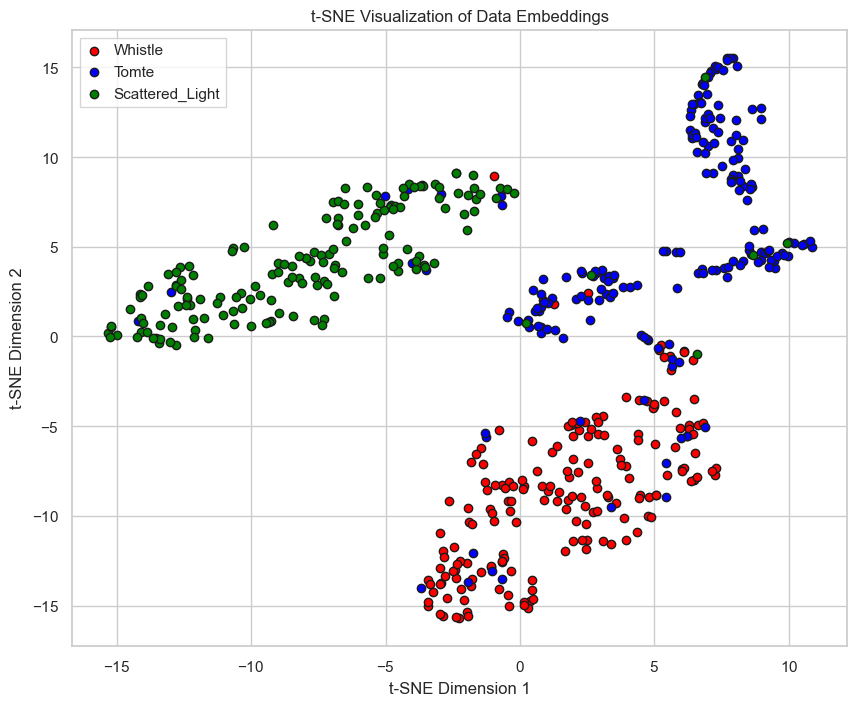

plot_tSNE_data_embedding: 1702.6560306549072 ms


In [159]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_DER_test.png")

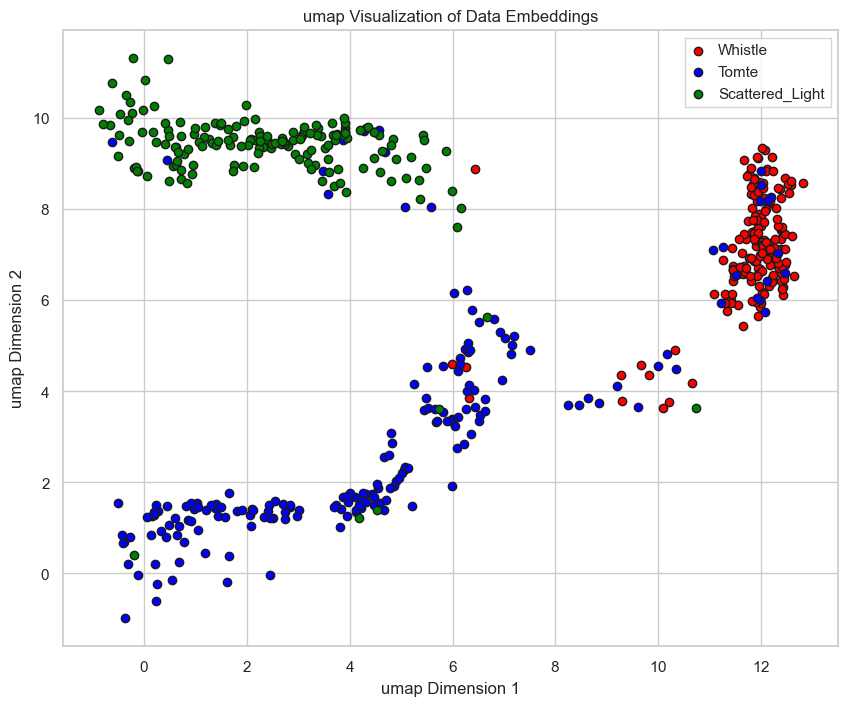

plot_umap_data_embedding: 6356.178045272827 ms


In [160]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_DER_test.png")

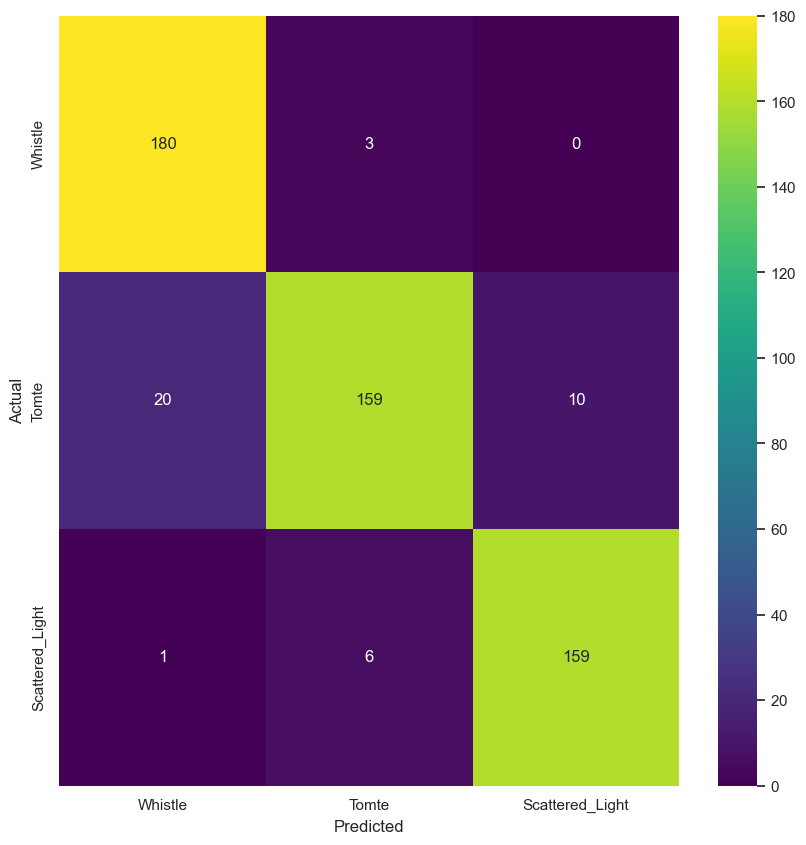

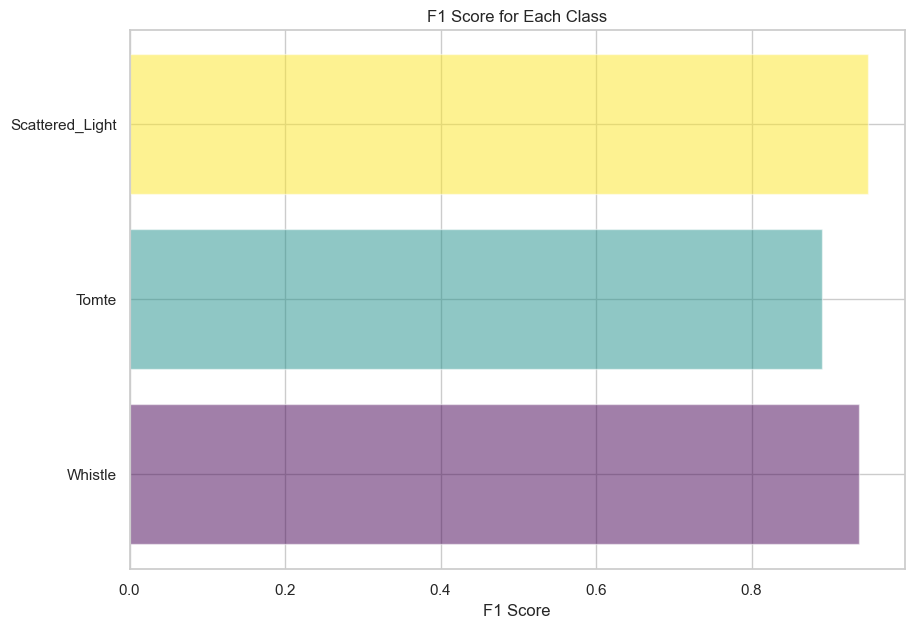

In [161]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_DER.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_DER.png')

## DER++ Continual strategy

In [26]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY DER++
cl_strategy = DER(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.5, beta=1.0, mem_size=500,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    #plugins=[ReplayPlugin(mem_size=2*len(train_set))]
)

Starting experiment with strategy: <avalanche.training.supervised.der.DER object at 0x000002749CCE8D00>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 13.57it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0705
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9755
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9755
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 14.28it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 13.74it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_

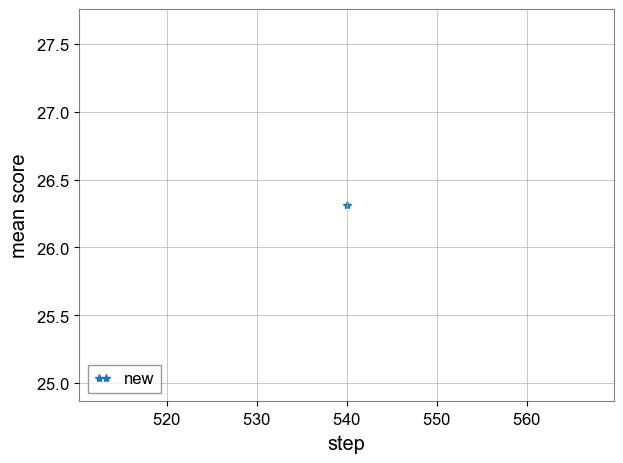

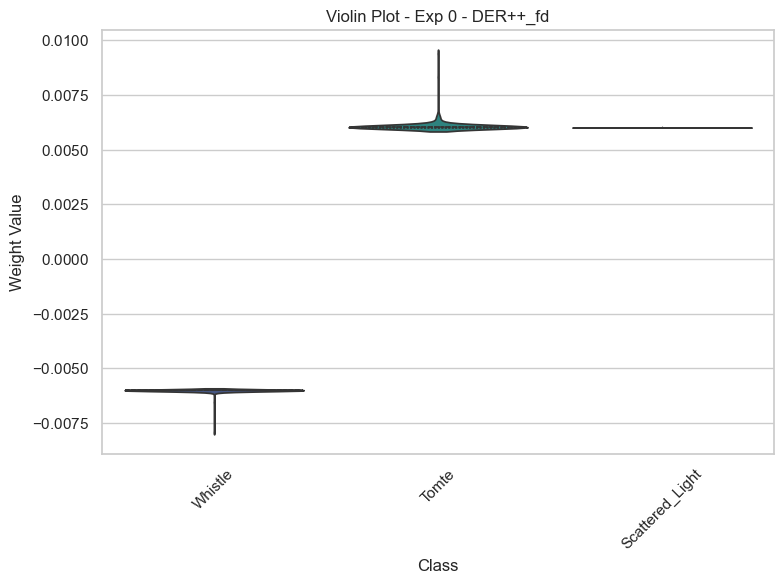

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:03<00:00, 10.84it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 66.5192
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8752
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9713
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.7768
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:02<00:00, 12.92it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 12.9568
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8632
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9949
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.7284
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:02<00:00, 13.83it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 8.1907
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9325
	Top1_Class

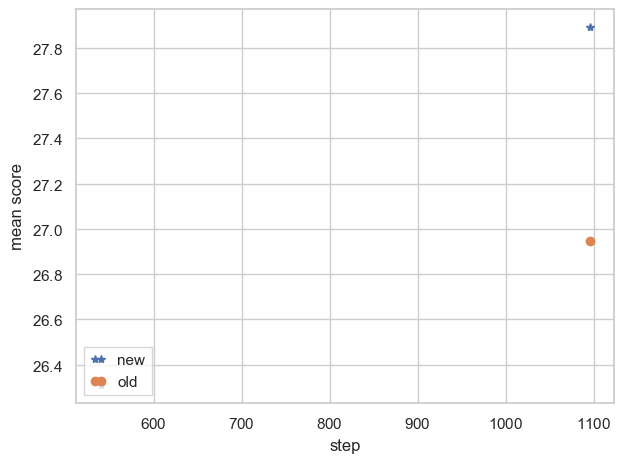

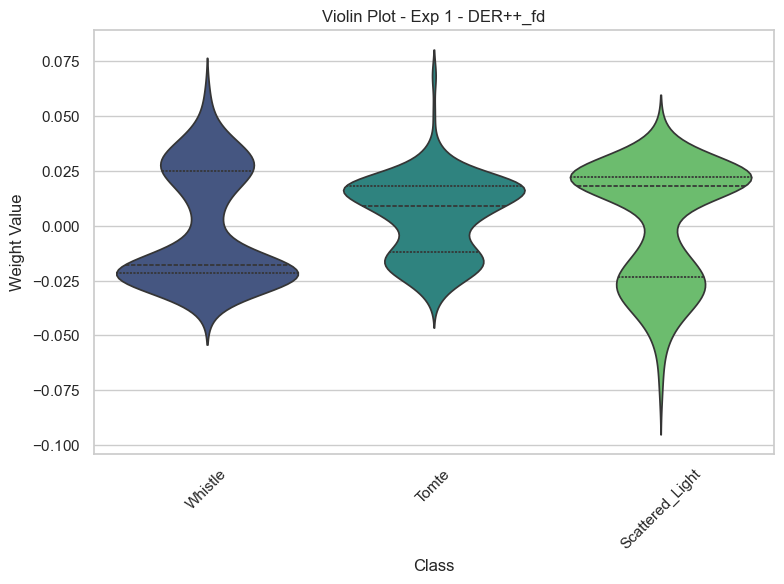

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 12.89it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 178.4794
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4908
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0105
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9329
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.77it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 118.7680
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6085
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.2364
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9556
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 14.00it/s]
Epoch 

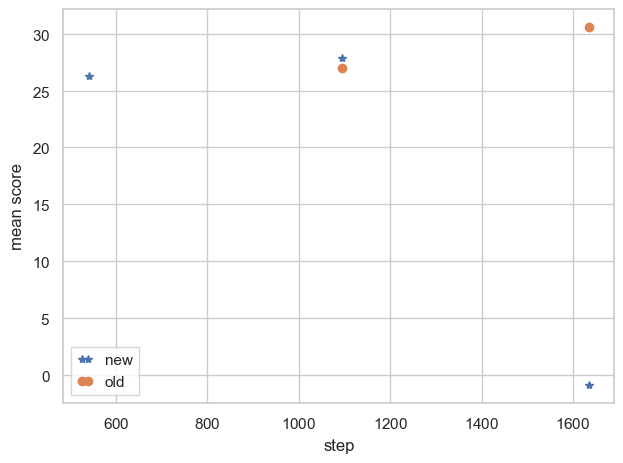

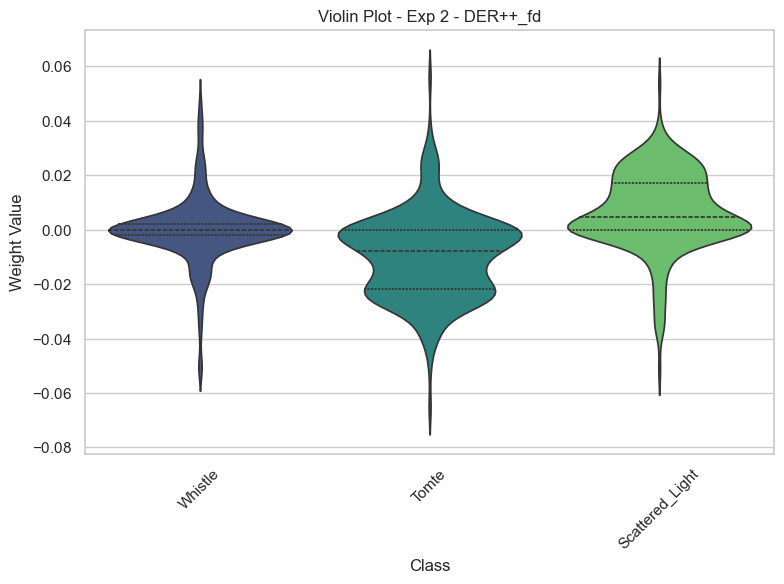

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 131519.8574066162 ms


In [27]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'DER++_fd', scr=False)

In [28]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 248.64983558654785 ms


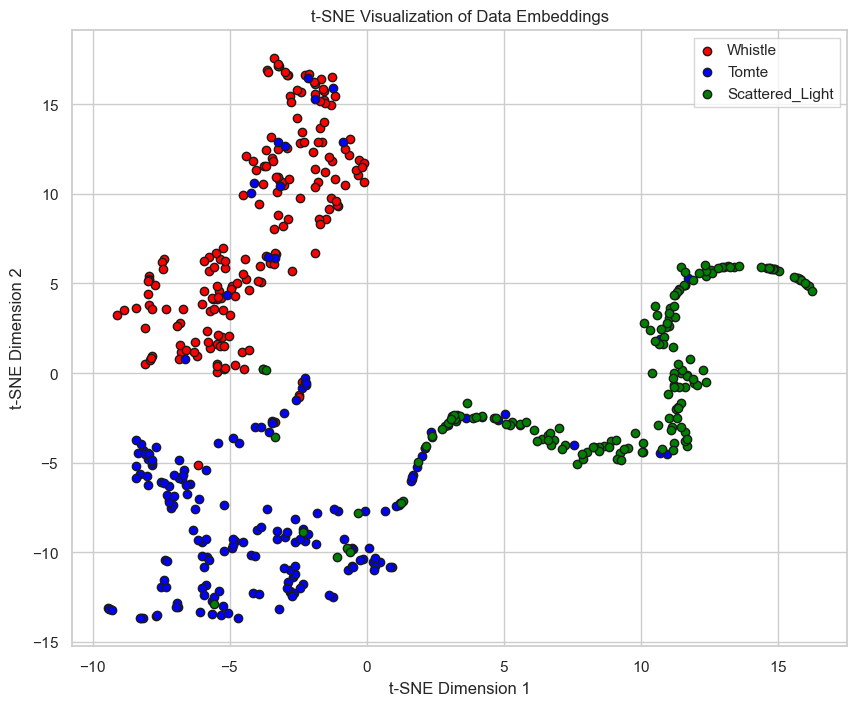

plot_tSNE_data_embedding: 1396.392822265625 ms


In [29]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_DER++_test.png")

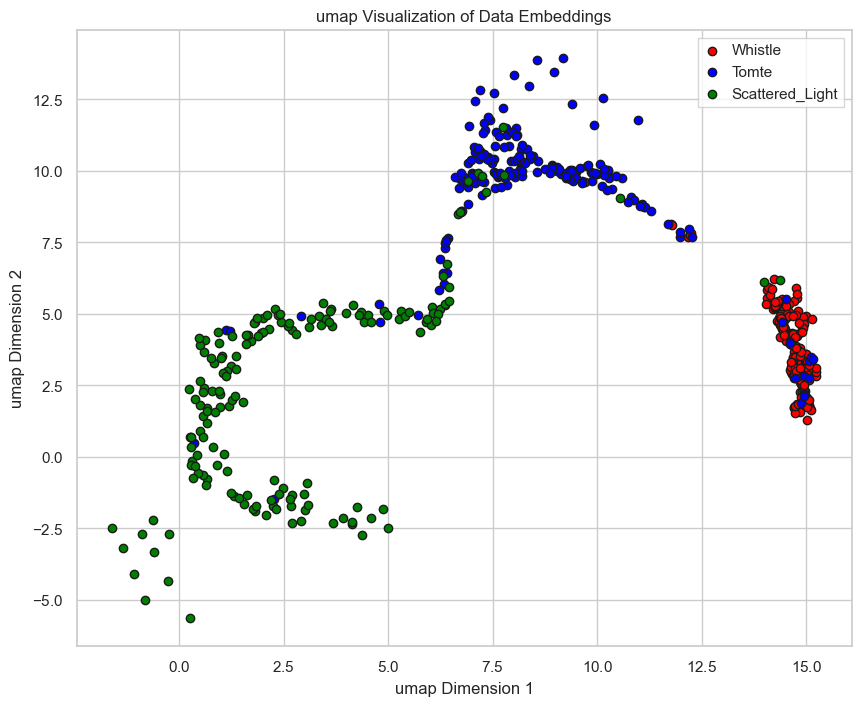

plot_umap_data_embedding: 12662.275791168213 ms


In [30]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_DER++_test.png")

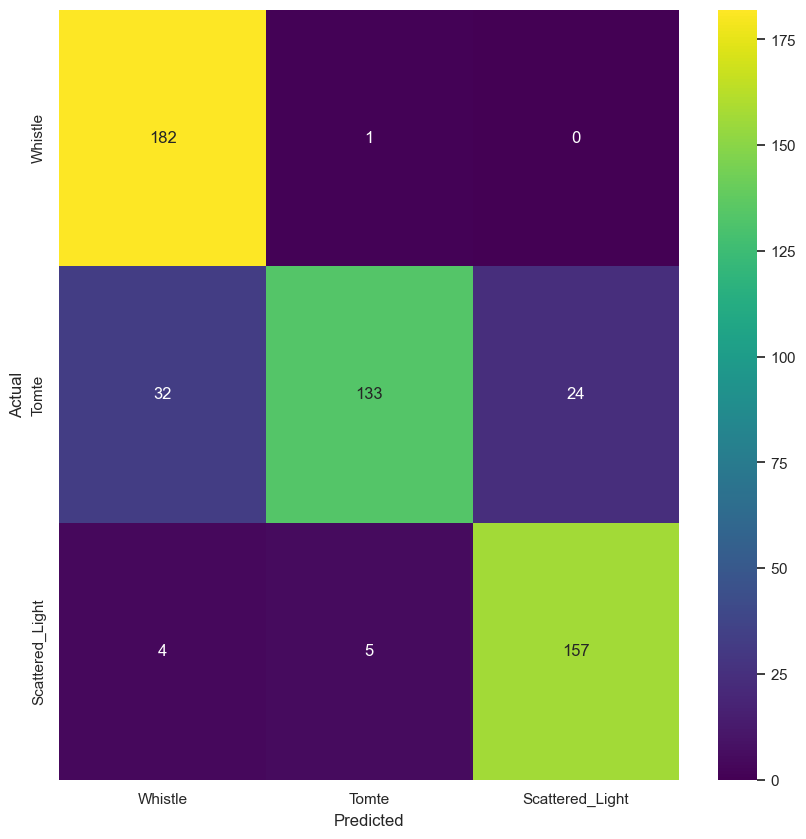

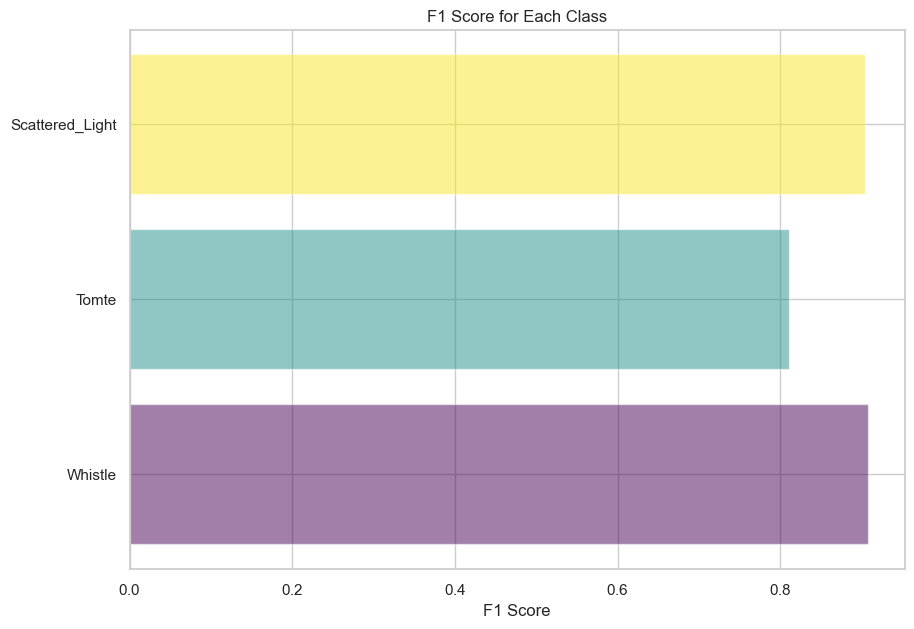

In [31]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_DER++.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_DER++.png')

## SCR Continual strategy

In [44]:
#### from avalanche.training import SCR, SCRLoss
from avalanche.models import SCRModel
extractor = my_architectures.FractalDimensionConvNet()
extractor.to(device)
projection = nn.Linear(3, 16)
projection.to(device)
scr_model = SCRModel(feature_extractor=extractor, projection=projection)
optimizer = SGD(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = SCRLoss()
scr_model.to(device)

SCRModel(
  (ncm): NCMClassifier()
  (feature_extractor): FractalDimensionConvNet(
    (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=3584, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
    (fc3): Linear(in_featu

In [55]:
# SCR STRATEGY
cl_strategy = SCR(
    model=scr_model, optimizer=optimizer, criterion=criterion, train_mb_size=16, train_epochs=15, 
    eval_mb_size=16, mem_size=1000, temperature=0.1, device=device, evaluator=eval_plugin
)

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    timing_metrics(experience=True, stream=True),
    gpu_usage_metrics(device.index, every=0.5, epoch=True, experience=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

Starting experiment with strategy: <avalanche.training.supervised.supervised_contrastive_replay.SCR object at 0x00000274C843A200>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:56<00:00,  1.57s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.8972
100%|██████████| 36/36 [00:01<00:00, 18.37it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.8970
100%|██████████| 36/36 [00:02<00:00, 17.61it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.8970
100%|██████████| 36/36 [00:01<00:00, 18.75it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.8968
100%|██████████| 36/36 [00:01<00:00, 19.48it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.8967
100%|██████████| 36/36 [00:01<00:00, 18.82it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.8967
100%|██████████| 36/36 [00:01<00:00, 19.76it/s]
Epoch 6 ended.
	Loss_Epoch/train_phase

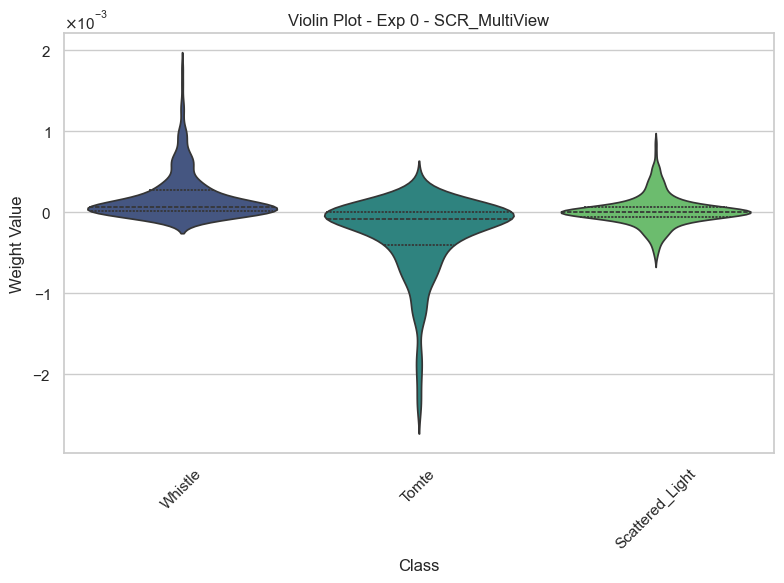

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:07<00:00,  5.05it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7181
100%|██████████| 37/37 [00:07<00:00,  5.06it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7177
100%|██████████| 37/37 [00:07<00:00,  5.19it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7168
100%|██████████| 37/37 [00:07<00:00,  4.81it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7150
100%|██████████| 37/37 [00:07<00:00,  4.87it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7107
100%|██████████| 37/37 [00:08<00:00,  4.20it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.7000
100%|██████████| 37/37 [00:08<00:00,  4.32it/s]
Epoch 6 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.6543
100%|██████████| 37/37 [00:09<00:00,  3.91it/s]
Epoch 7 ended.
	Loss_Epoch/train_phase/train_stream

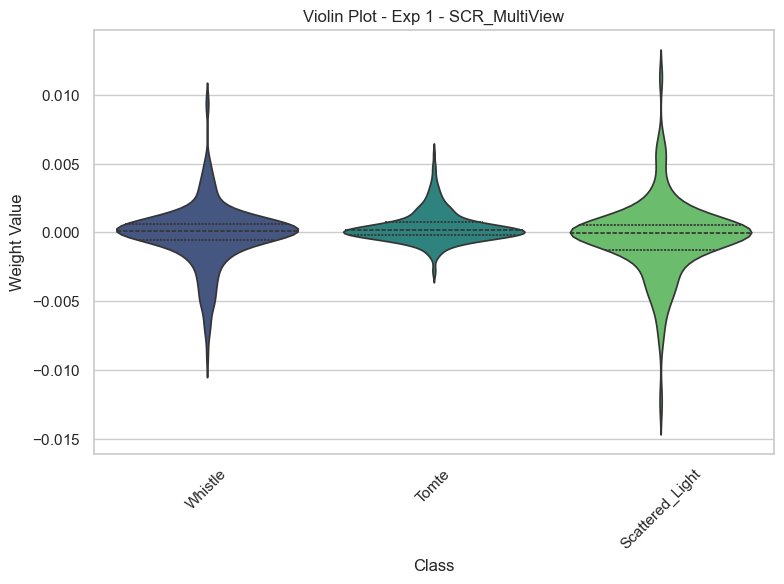

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:09<00:00,  3.89it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.0446
100%|██████████| 36/36 [00:08<00:00,  4.19it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 6.9681
100%|██████████| 36/36 [00:08<00:00,  4.15it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 6.9197
100%|██████████| 36/36 [00:07<00:00,  4.52it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 6.8848
100%|██████████| 36/36 [00:08<00:00,  4.18it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 6.8529
100%|██████████| 36/36 [00:08<00:00,  4.49it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 6.8162
100%|██████████| 36/36 [00:08<00:00,  4.19it/s]
Epoch 6 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 6.7956
100%|██████████| 36/36 [00:08<00:00,  4.46it/s]
Epoch 7 ended.
	Loss_Epoch/train_phase/train_stream

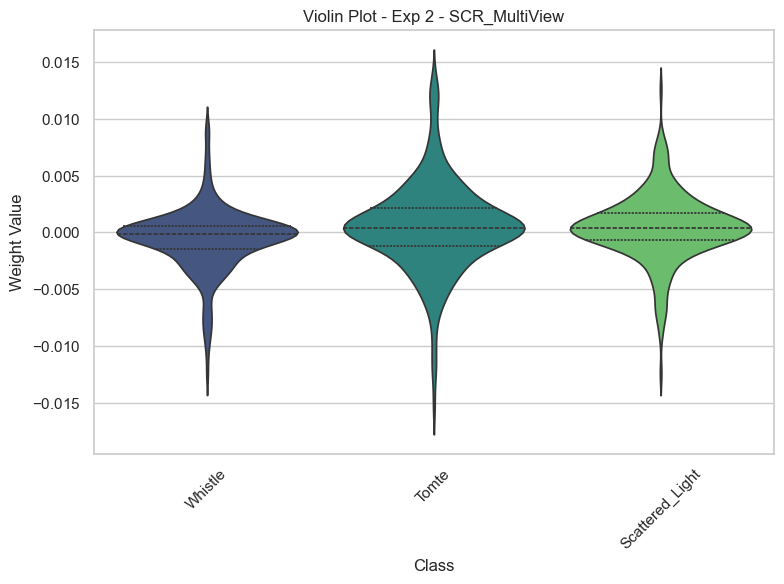

Stored metrics: ['Loss_Epoch/train_phase/train_stream/Task000']
cl_simple_train_loop: 288591.3760662079 ms


In [56]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, scr_model, optimizer, number_of_workers, classes, 'SCR_MultiView', scr=True)

In [57]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 236.96112632751465 ms


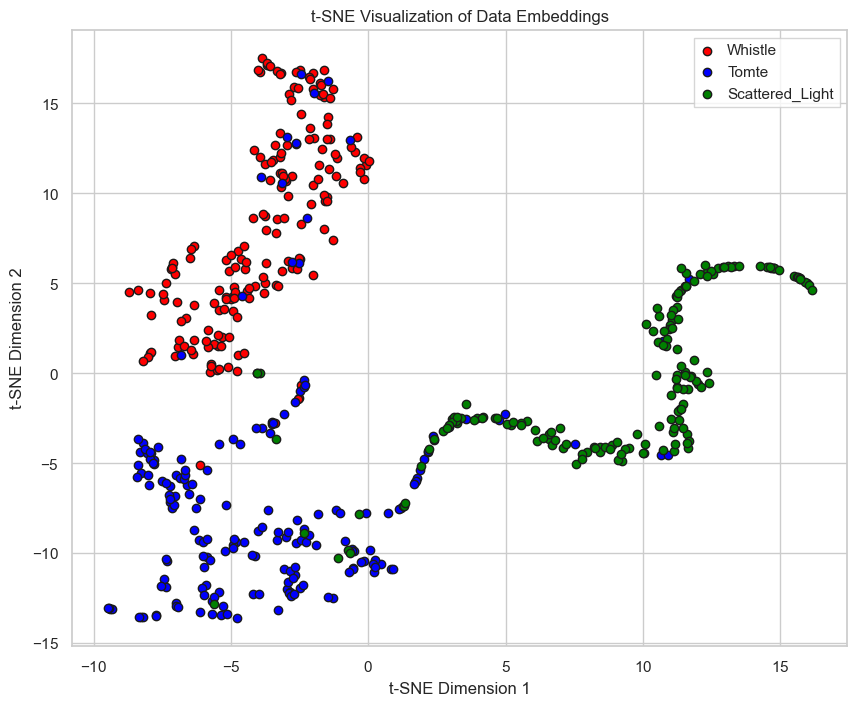

plot_tSNE_data_embedding: 1159.9063873291016 ms


In [58]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_SCR_test.png")

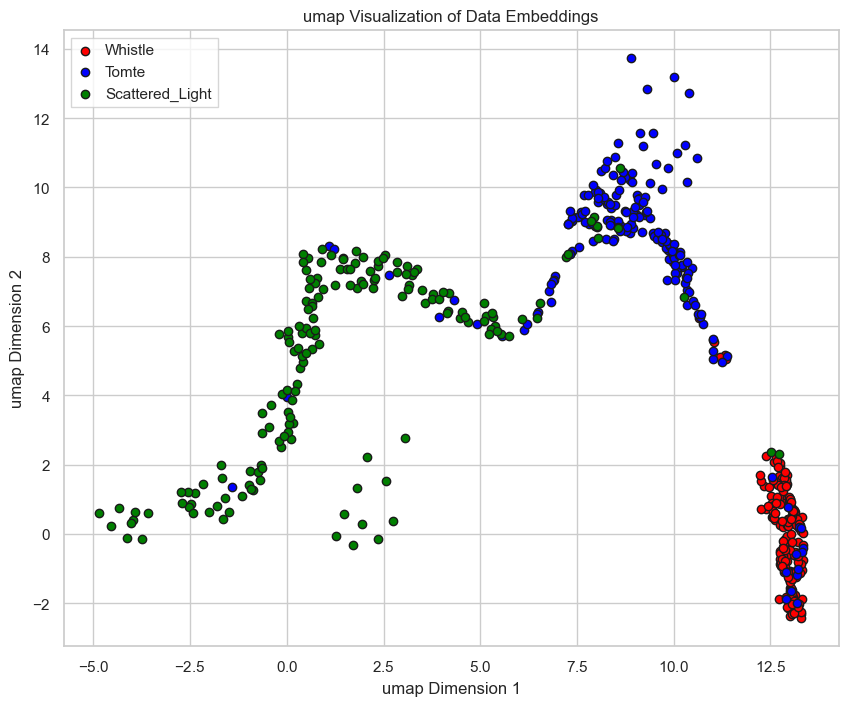

plot_umap_data_embedding: 7301.403760910034 ms


In [59]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_SCR_test.png")

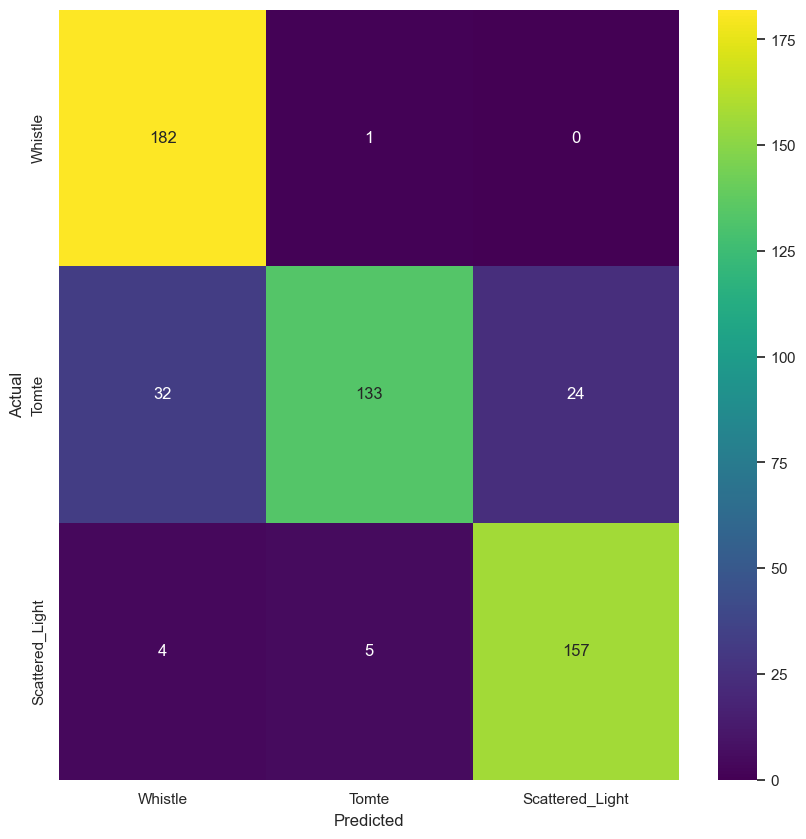

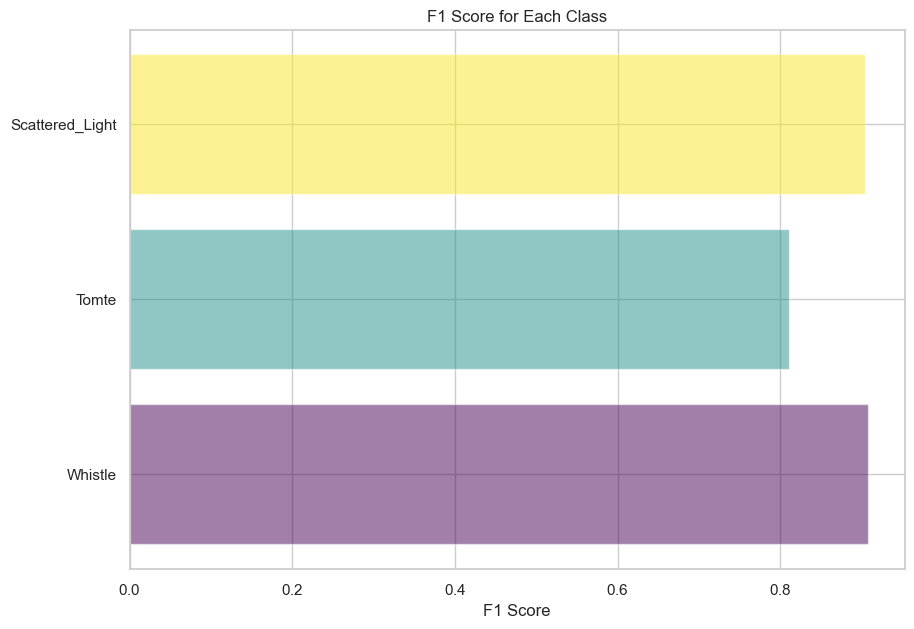

In [60]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_SCR.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_SCR.png')